# Loading modules/functions

In [1]:
#
# Jupyter python notebook to estimate ARGO Oxygen Correction.
# DOXY_ADJUSTED is corrected via the correction of the partial pressure PPOX as in 'Bittig and al (2018)'
# https://dx.doi.org/10.3389/fmars.2017.00429

#instruction to be able to zoom on matplotlib figure
%matplotlib widget 

# Path to LOCODOX python
import sys
sys.path.insert(0,'/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/source')

# Import python module
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
from datetime import date, datetime
import copy
import pwlf
#from wrangling import interp_climatology


# Import module developped for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, copy_attr, write_param_results, interp_climatology_float
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_Gain_pres, model_AXplusB
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa, plot_Theta_S, plot_CTD_Argo_Pos, plot_cmp_corr_NCEP_with_error, plot_cmp_corr_WOA_with_error, plot_ref_div_argo
from m_users_plot import plot_cmp_correction_with_WOA
from m_read_write_netcdf import corr_file, corr_file_with_ppox

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_18280/2518682701.py:24: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


# User initialization

In [2]:
#####################
# Initialization.
###################

# ARGO Directory : contains 1 subdirectory by float.
# In the Argo float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
# WMO Float (string format) to be corrected / Cycles to be used
#################################################################
# Argo directory
#rep_data_argo = '/Volumes/argo/gdac/dac/coriolis/'
rep_data_argo = '/Volumes/argo/gdac/dac/coriolis/'
# Argo float
#num_float = '6902882' 
num_float = '6902982' #'6902802'
# Cycle to use to estimate the correction
first_cycle_to_use = 1
last_cycle_to_use = 400


# Results Directory.
# A subdirectory named numfloat_date will be created for each run in the result directory.
# The ASCII file will be created in it.
# The B corrected files and plots will be created in a subdirectory (nc and plot subdirectory)
###################################################
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
now = datetime.now()
date_str = now.strftime("%Y%m%d%H%M")
rep_fic_res_final = os.path.join(rep_fic_res,num_float + '_' + date_str)
rep_fic_fig = os.path.join(rep_fic_res_final,'plot') # Plot
rep_fic_nc = os.path.join(rep_fic_res_final,'nc') # NetCDF
os.makedirs(rep_fic_res_final, exist_ok=True)
os.makedirs(rep_fic_fig, exist_ok=True)
os.makedirs(rep_fic_nc, exist_ok=True)
# ASCII file name
racine_res = 'locodox_res_'
fic_res_ASCII = os.path.join(rep_fic_res_final,racine_res + num_float)

# Default pressure coefficient used in ARGO
# sensor_aanderaa = 1 if aanderaa sensor, 0 if rinko sensor
sensor_aanderaa = 1
if sensor_aanderaa == 1:
    racine_res = racine_res + 'aanderaa_' 
    pcoef2 = 0.00022
    pcoef3 = 0.0419
else:
    racine_res = racine_res + 'rinko_' 
    pcoef2 = 0
    pcoef3 = 0.04

# Relative error to be written in the BD files
percent_relative_error = 2.0

# Which plot ?
###############
# info_plot = 1 : all plots
# info_plot = 0 : not all plots are created.
info_plot = 1 

# Which ARGO variables (PRES/PSAL/TEMP) to be used to estimate correction.
#################################################
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 3
if which_var==1:
    str_chaine = ''
else:
    str_chaine='_ADJUSTED'

# Which QC used for pressure, temperature, salinity and oxygen.
# In Sprof, we got interpolated data (flag=8)
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

# CTD comparison to estimate a supplement gain.
##################################################
# cmp_ctd = 1 : we used CTD, 0 otherwise
cmp_ctd = 1
# rep_ctd : CTD directory
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
# num_ctd : CTD to be compared with cycle. 
rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/']
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
fic_ctd = ['bo21_PRES.nc'] #['ovid18_PRES.nc'] 
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
num_cycle = np.array([7]) #np.array([1]) #np.array([5]) 
# num_ctd : CTD to be compared with cycle. 
# num_cycle[I] is compared with num_ctd[I].
num_ctd = np.array([22]) #np.array([81])  #np.array([7]) 

# Pressure effect 
###################
# Pressure for pressure effect estimation. We use pressure > pressure_threshold
pressure_threshold = 1000  

# Bathymetry plot
# Bathymetry file
fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
#  Dataset associated
ds_bathy = xr.open_dataset(fic_bathy)
# extension for Position plot
extend_lon_lat = 0.5
# Depth for bathymetry contouring
depths = np.arange(-7000,500,500)

# WOA correction
##################
# fic_woa : WOA file
# Tis file contains the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# This file is created by an internal LOPS routine. !!! To change !!!
#
# WOA file
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'
# Min and max pressure used to estimate WOA correction. 
min_pres_interp = 0
max_pres_interp = 25

# NCEP Correction
######################
# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO reading and selection
## We use the NetCDF Argo file 
- meta file
- Sprof file
- Rtraj file

In [3]:
# Read ARGO files 
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/argo/gdac/dac/coriolis/6902982/6902982_meta.nc
/Volumes/argo/gdac/dac/coriolis/6902982/6902982_Sprof.nc
/Volumes/argo/gdac/dac/coriolis/6902982/6902982_Rtraj.nc


In [4]:
# Launch data
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)
# Delta time from launch date
delta_T_Sprof = diff_time_in_days(ds_argo_Sprof['JULD'],launch_date)

2021-06-05T18:10:00.000000000
-0.3


In [5]:
# Select the cycles to be used
ds_argo_Sprof = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Sprof['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Rtraj = ds_argo_Rtraj.where( (ds_argo_Rtraj['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Rtraj['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Sprof['PLATFORM_NUMBER'] = ds_argo_Sprof['PLATFORM_NUMBER'].astype(int) # The where transform the nan from int to float ...

In [6]:
# Check ds_argo_Sprof
ds_argo_Sprof

<xarray.Dataset> Size: 14MB
Dimensions:                       (N_PROF: 58, N_PARAM: 4, N_CALIB: 2,
                                   N_LEVELS: 1942)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     (N_PROF) object 464B 'Argo synthetic profil...
    FORMAT_VERSION                (N_PROF) object 464B '1.0 ' '1.0 ' ... '1.0 '
    HANDBOOK_VERSION              (N_PROF) object 464B '1.2 ' '1.2 ' ... '1.2 '
    REFERENCE_DATE_TIME           (N_PROF) datetime64[ns] 464B 1950-01-01 ......
    DATE_CREATION                 (N_PROF) datetime64[ns] 464B 2024-12-05T12:...
    DATE_UPDATE                   (N_PROF) datetime64[ns] 464B 2024-12-05T12:...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 451kB 243.0 ... nan
    DOXY_QC                       (N_PROF, N_LEVELS) float64 901kB 4.0 ... 0.0
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 451kB 0.0 ... nan
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 451kB nan ... nan
    DOXY_ADJUSTED_QC              (N_PROF, N_LEVELS) float64 901kB 4.0 ... 0.0
    DOXY_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 451kB nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-05T12:24:56Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

# Plots

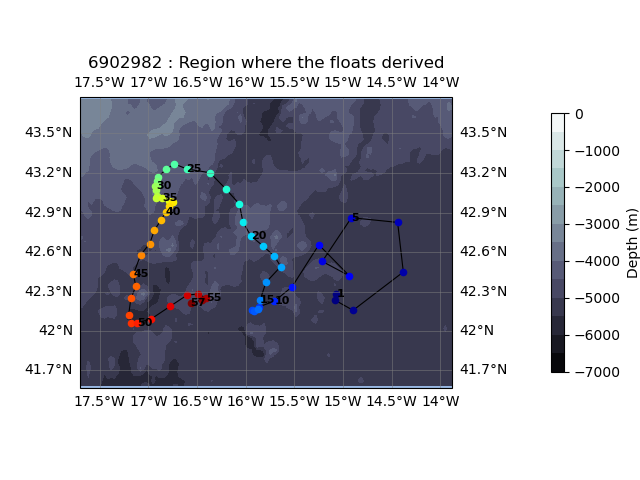

In [7]:
# Maps plotting
if info_plot==1:
    ds_bathy = xr.open_dataset(fic_bathy)
    extend_lon_lat = 0.5
    depths = np.arange(-7000,500,500)
    plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_pos.png'))

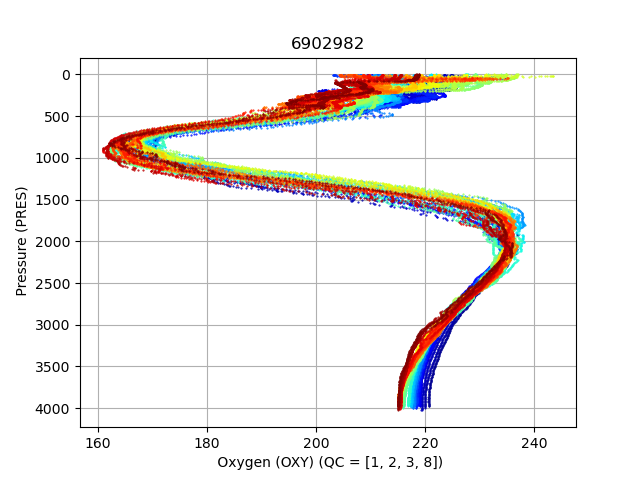

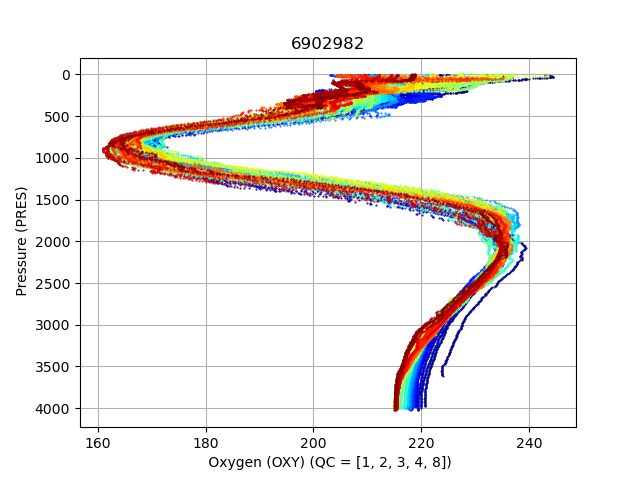

In [8]:
# DOXY RAW DATA
_=plot_DOXY_cycle(ds_argo_Sprof,qc_keep=[1,2,3,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_cycle.png'))
_=plot_DOXY_cycle(ds_argo_Sprof) # qc_keep = [1,2,3,4,8] by default

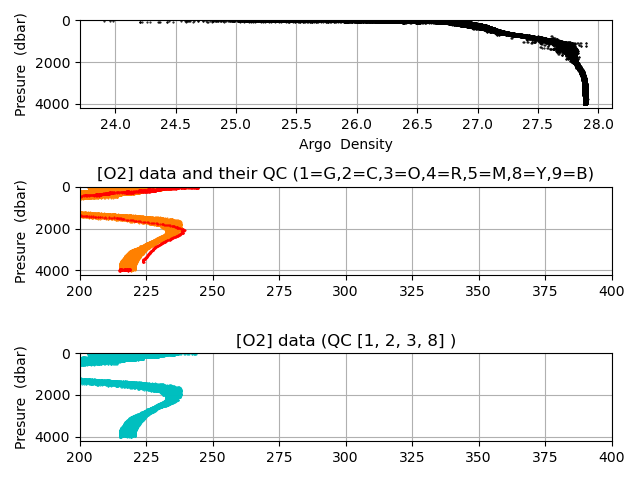

In [9]:
# DOXY_QC plot with PRES/PSAL/TEMP
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc.png'))

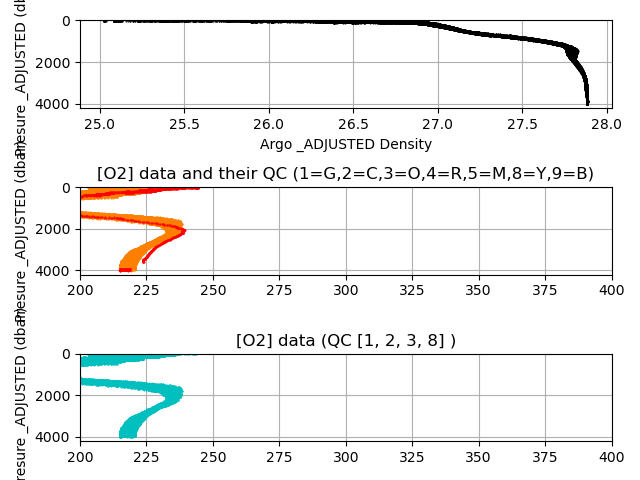

In [10]:
# Same with DATA ADJUSTED (PRES,PSAL,TEMP)
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc_PTS_adjusted.png'))

PRES
TEMP
PSAL


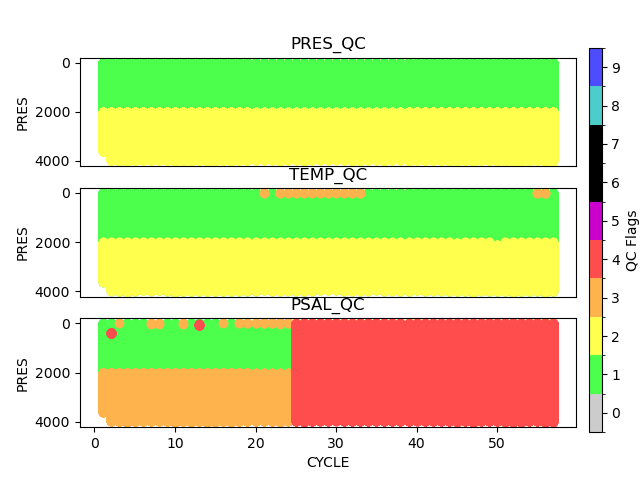

In [11]:
# PRES/PSAL/TEMP QC
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_QC.png'))

PRES_ADJUSTED
TEMP_ADJUSTED
PSAL_ADJUSTED


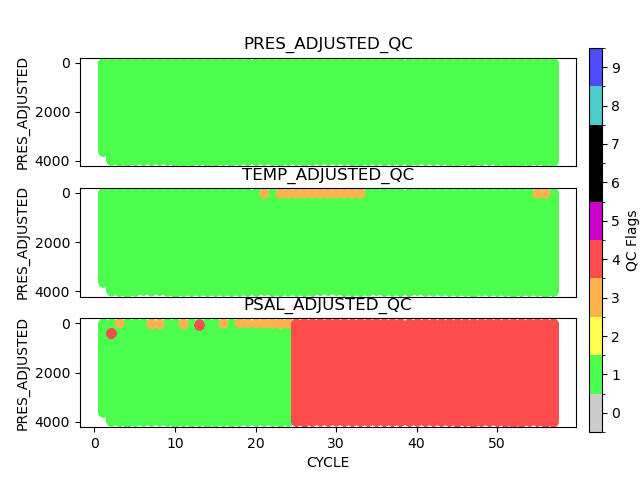

In [12]:
# Same with adjusted DATA
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_Adjusted_QC.png'))

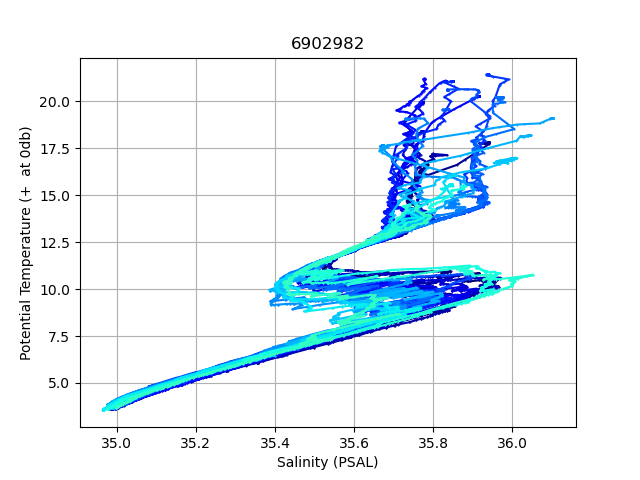

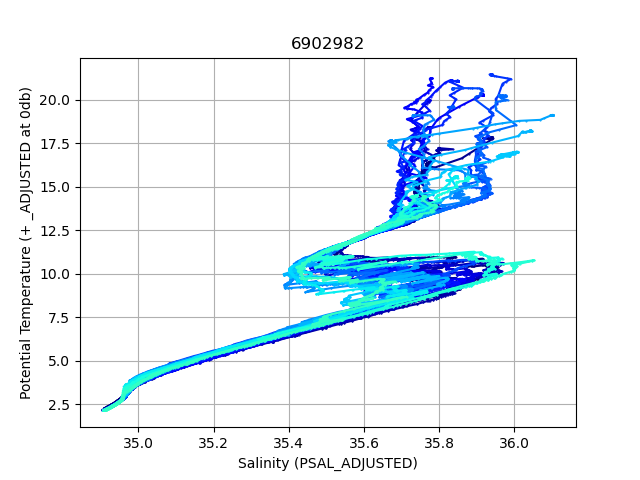

In [13]:
# Theta/S
#_=plot_Theta_S(ds_argo_Sprof)
#_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED')
_=plot_Theta_S(ds_argo_Sprof,qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S.png'))
_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED',qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S_adjusted.png'))



# Get WOA and NCEP DATA
- Attention : The WOA file is a LOPS home-made file

In [14]:
# WOA file reading
ds_woa = open_WOA_file(fic_WOA)
#download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

WOA : We force Longitude in [-180 180]


# Prepare data for WOA Correction

In [15]:
################################## 
# Correction estimated with WOA
##################################
# ARGO data needed for WOA correction.
# ds_argo contains variables needed to estimate correction with WOA.
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)
ds_argo

PSAL ADJUSTED Data Used if available, otherwise Raw Data Used
PRES ADJUSTED Data Used if available, otherwise Raw Data Used
TEMP ADJUSTED Data Used if available, otherwise Raw Data Used


<xarray.Dataset> Size: 5MB
Dimensions:       (N_PROF: 58, N_LEVELS: 1942)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    TEMP_ARGO     (N_PROF, N_LEVELS) float32 451kB 16.01 16.01 15.97 ... nan nan
    TEMP_ARGO_QC  (N_PROF, N_LEVELS) float64 901kB 8.0 1.0 8.0 ... 0.0 0.0 0.0
    PSAL_ARGO     (N_PROF, N_LEVELS) float32 451kB 35.73 35.73 35.74 ... nan nan
    PSAL_ARGO_QC  (N_PROF, N_LEVELS) float64 901kB 8.0 1.0 8.0 ... 0.0 0.0 0.0
    DOXY_ARGO     (N_PROF, N_LEVELS) float32 451kB nan nan nan ... nan nan nan
    DOXY_ARGO_QC  (N_PROF, N_LEVELS) float64 901kB 4.0 0.0 4.0 ... 0.0 0.0 0.0
    PRES_ARGO     (N_PROF, N_LEVELS) float32 451kB 13.2 13.5 13.9 ... nan nan
    PRES_ARGO_QC  (N_PROF, N_LEVELS) float64 901kB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    JULD          (N_PROF) datetime64[ns] 464B 2021-06-05T20:27:00.000000256 ...
    LONGITUDE     (N_PROF) float64 464B -15.07 -15.08 -14.9 ... -16.45 -16.57
    LATITUDE      (N_PROF) float64 464B 42.28 42.23 42.16 ... 42.25 42.24 42.21
    CYCLE_NUMBER  (N_PROF) float64 464B 1.0 1.0 2.0 3.0 ... 54.0 55.0 56.0 57.0
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-05T12:24:56Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

In [16]:
# Delta Times from launch_date
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [17]:
# Interp WOA data on ARGO time
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)
ds_woa_interp_on_ARGO

WOA time Extrapolation for interpolation

<xarray.Dataset> Size: 4GB
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 112B -15.25 15.0 46.0 75.0 ... 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    density   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
101.86589

<xarray.Dataset> Size: 286kB
Dimensions:   (N_LEVELS: 102, N_PROF: 58)
Coordinates:
  * Depth     (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
    lat       (N_PROF) float64 464B 42.28 42.23 42.16 ... 42.25 42.24 42.21
    lon       (N_PROF) float64 464B -15.07 -15.08 -14.9 ... -16.41 -16.45 -16.57
    time      (N_PROF) int64 464B 156 158 168 178 188 ... 313 323 333 343 353
Dimensions without coordinates: N_LEVELS, N_PROF
Data variables:
    doxywoa   (N_LEVELS, N_PROF) float64 47kB 256.1 254.9 249.5 ... nan nan nan
    Psatwoa   (N_LEVELS, N_PROF) float64 47kB 106.0 105.8 105.0 ... nan nan nan
    density   (N_LEVELS, N_PROF) float64 47kB 1.026e+03 1.026e+03 ... nan nan
    preswoa   (N_LEVELS, N_PROF) float64 47kB 0.0 0.0 0.0 0.0 ... nan nan nan
    PSAL_WOA  (N_LEVELS, N_PROF) float64 47kB 35.83 35.84 35.85 ... nan nan nan
    TEMP_WOA  (N_LEVELS, N_PROF) float64 47kB 16.02 16.16 16.81 ... nan nan nan

In [18]:
# Interpolation WOA et ARGO on regular grid (defined at the beginning)
print(f"WOA/ARGO Interpolation between {min_pres_interp} et {max_pres_interp}")
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

WOA/ARGO Interpolation between 0 et 25
Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [19]:
ds_woa_interp

<xarray.Dataset> Size: 72kB
Dimensions:   (N_PROF: 58, N_LEVELS: 26)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    doxywoa   (N_PROF, N_LEVELS) float64 12kB 256.1 256.5 257.0 ... 253.0 252.9
    Psatwoa   (N_PROF, N_LEVELS) float64 12kB 106.0 106.2 106.4 ... 102.3 102.2
    density   (N_PROF, N_LEVELS) float64 12kB 1.026e+03 1.026e+03 ... 1.027e+03
    preswoa   (N_PROF, N_LEVELS) float64 12kB 0.0 1.0 2.0 3.0 ... 23.0 24.0 25.0
    PSAL_WOA  (N_PROF, N_LEVELS) float64 12kB 35.83 35.83 35.83 ... 35.85 35.85
    TEMP_WOA  (N_PROF, N_LEVELS) float64 12kB 16.02 16.0 15.99 ... 14.84 14.84

In [20]:
ds_argo_interp

<xarray.Dataset> Size: 97kB
Dimensions:       (N_PROF: 58, N_LEVELS: 26)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    TEMP_ARGO     (N_PROF, N_LEVELS) float64 12kB nan nan nan ... 15.32 15.32
    TEMP_ARGO_QC  (N_PROF, N_LEVELS) float64 12kB nan nan nan ... 8.0 8.0 7.125
    PSAL_ARGO     (N_PROF, N_LEVELS) float64 12kB nan nan nan ... nan nan nan
    PSAL_ARGO_QC  (N_PROF, N_LEVELS) float64 12kB nan nan nan ... 4.0 4.0 4.0
    DOXY_ARGO     (N_PROF, N_LEVELS) float64 12kB nan nan nan ... 218.6 218.7
    DOXY_ARGO_QC  (N_PROF, N_LEVELS) float64 12kB nan nan nan ... 3.0 3.0 2.625
    PRES_ARGO     (N_PROF, N_LEVELS) float64 12kB nan nan nan ... 23.0 24.0 25.0
    PRES_ARGO_QC  (N_PROF, N_LEVELS) float64 12kB nan nan nan ... 1.0 1.0 1.0

In [21]:
# Add attributes in data interp 
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [22]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

In [23]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

# Prepare data for NCEP Correction
## We recover the InAir data and InWater Argo Data from the Rtraj file.
- In the Rtraj file, the pump is off. So, we decide to take the salinity from the Sprof file, near the surface (between min_pres and max_pres defined by the user)
- In the RTraj file, all TEMP_QC is 3. But we decide to take it into account because the temperature is important to calculate the watervapor. <br>
  The temperature in the Rtraj is closer to the InAir and InWater data. So, we use it. We compare it to the Temperature from the Sprof and a message is written if the difference is >0.5.
- So, this salinity and temperature are used to calculate NCEP PPOX
- NCEP PPOX is calculated from the article 'Tackling Oxygen Optode Drift : Near Surface and In-Air Oxygen optode Measurements on a float provide an accurate in situ Reference' <br>
 (Bittg and al. 2015) : <br>
     - PPOX_air = 0.20946 * (P_air - P_vap) where P_air = Atmospheric pressure, P_vap : water vapor scaled to the optode height
     - P_vap = P_vap_S + (Rhum_10m * P_vap_10m - P_vap_S) * ln(optode_height / 1e-4)/ln(10/1e-4) avec <br>
         - P_vap_S : seasurface water vapor pressure
         - P_vap_1Om : ncep water vapor at 10m
         - Rhum_10m : relative humidity at 10m

We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


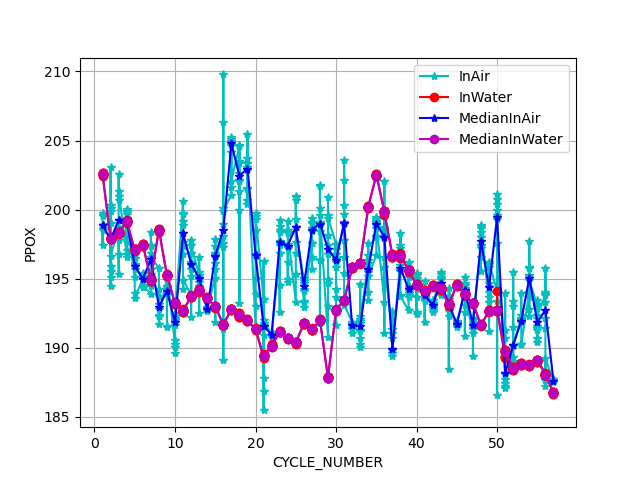

PSAL_ADJUSTED is used if exists, otherwise PSAL.

Cycle 8.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature
Cycle 11.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature
Cycle 17.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature
Cycle 35.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature
Cycle 48.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature


In [24]:
# Get ARGO PPOX inair/inwater for NCEP correction
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
plt.savefig(os.path.join(rep_fic_fig,num_float +'_InAir_InWater.png'))


In [25]:
# Compute NCEP data at ARGO time
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [26]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)

# Plot REF/ARGO
The correction used is :
- Ref = (G * (1 + D/100 * deltaT / 365)) * (data + Offset) <br>
 Attention : Offset is supposed to be 0 (and so is not estimated) <br>
G is the gain <br>
D is the time drift <br>
deltaT is the time, in days, from the launch date
- So, Ref/data is : (G * (1 + D/100 * deltaT / 365)) = A * deltaT + B <br>
  The correction is a straight line as a function of deltaT.

  The plot shows this correction. It can help the user to choose if he has to choose a piece wise correction or not.
## Ref_WOA/ppox_Argo


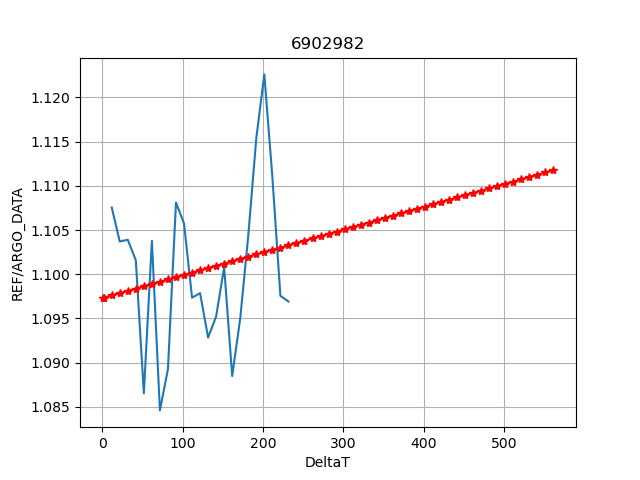

In [27]:
plot_ref_div_argo(delta_T_WOA,ppox_WOA_mean,ppox_ARGO_mean,num_float)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_ref_div_WOA_deltaDays.png'))

## Ref_NCEP/ppox_ARGO

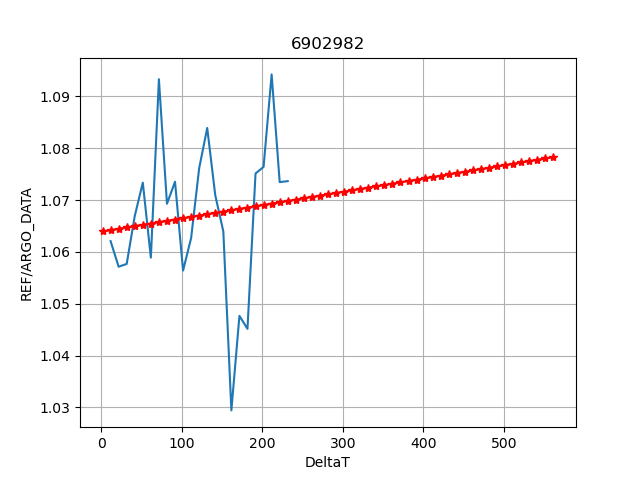

In [28]:
plot_ref_div_argo(delta_T_NCEP,NCEP_PPOX,PPOX1,num_float)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_ref_div_NCEP_deltaDays.png'))

# Correction estimation (without piece, just 1 segment)
We calculate the correction on the the oxygen partial pressure (PPOX)
## WOA Correction
- 2 possible corrections :
    - a gain : Ref/data = G 
    - a gain and a time drift : Ref/data = (G + (1 * D * deltaT/365)) <br>
We use curve_fit for G (gain) and D (time drift) estimation

In [29]:
# Correction WOA : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')
perr_Gain_WOA = np.sqrt(np.diag(covariance))
print(f"WOA Gain estimated : {params_Gain_WOA} with an error {perr_Gain_WOA}")


WOA Gain estimated : [1.10044407] with an error [0.00192554]


In [30]:
# Correction WOA : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_Derive_WOA = np.sqrt(np.diag(covariance))
print(f"WOA Gain/Drift estimated : {params_Gain_Derive_WOA} with an error {perr_Gain_Derive_WOA}")


WOA Gain/Drift estimated : [1.09731569 0.85625171] with an error [0.00403943 0.97322755]


## NCEP Correction
- 4 possible corrections:
    - a gain (G)
    - a gain (G) estimated with CarryOver (C)
    - a gain (G) and a time drift (D)
    - a gain (G) and a time drift (D) estimated with CarryOver (C) <br>
We use curve_fit for G, D and C estimation. <br>
The Carryover represents the fact that the InAir Argo PPOX may be polluted by water (waves) <br>
The CarryOver is determinated by the article 'Oxygen Optode Sensors : Principle, characterization, calibration and application in the Ocean' <br>
(Bittig and al. 2018) : <br>
        - G * PPOX_obs_sufr - PPOX_air = C * (G * PPOX_obs_water - PPOX_air)

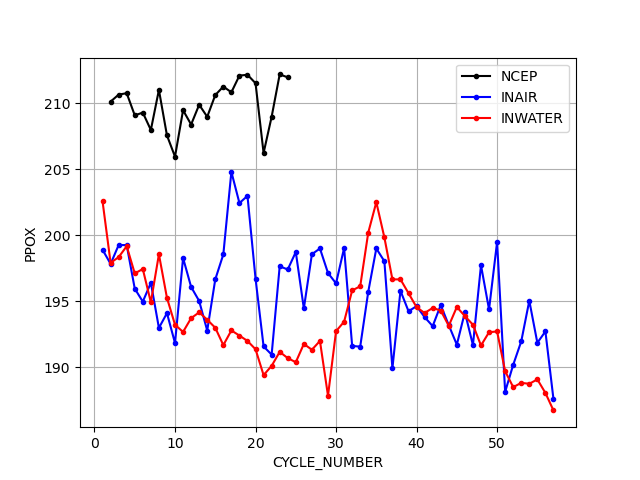

In [31]:
# Plot NCEP and ARGO PPOX
_ = plot_ppox_Inair_Inwater_Ncep(dsair,dsinwater,NCEP_PPOX)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_NCEP_InAir_InWater.png'))

In [32]:
# Estimate Gain correction with NCEP 
# without CarryOver
initial_guess = 1
# Gain
params_Gain_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_NCEP = np.sqrt(np.diag(covariance))
print(f"NCEP Gain estimated : {params_Gain_NCEP} with an error {perr_Gain_NCEP}")

# with CarryOver
initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
perr_Gain_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(f"NCEP Gain/CarryOver estimated : {params_Gain_NCEP_CarryOver} with an error {perr_Gain_NCEP_CarryOver}")


NCEP Gain estimated : [1.06701353] with an error [0.00308943]
NCEP Gain/CarryOver estimated : [1.06697343e+00 6.66058865e-08] with an error [0.003251   0.02395264]


In [33]:
# Estimate Gain/Drift correction with NCEP 
# without CarryOver
initial_guess = [1, 0]  # G/C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_Derive_NCEP = np.sqrt(np.diag(covariance))
print(f"Gain/Drift estimated : {params_Gain_Derive_NCEP} with an error {perr_Gain_Derive_NCEP}")

# with CarryOver
initial_guess = [1, 0, 0]  # G/C/D
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
perr_Gain_Derive_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(f"Gain/CarryOver/Drift estimated : {params_Gain_Derive_NCEP_CarryOver} with an error {perr_Gain_Derive_NCEP_CarryOver}")


Gain/Drift estimated : [1.06390013 0.8787962 ] with an error [0.00655528 1.62893303]
Gain/CarryOver/Drift estimated : [ 1.03974913e+00 -1.55687803e-07  6.40864039e+00] with an error [0.0094143  0.09078878 2.43711653]


In [34]:
# We don't need the CarryOver value.
params_Gain_NCEP_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
params_Gain_Derive_NCEP_CarryOver = np.array(params_Gain_Derive_NCEP_CarryOver[[0,2]])
perr_Gain_NCEP_CarryOver = np.array([perr_Gain_NCEP_CarryOver[0]])
perr_Gain_Derive_NCEP_CarryOver = np.array(perr_Gain_Derive_NCEP_CarryOver[[0,2]])

In [35]:
dict_corr = {'Gain WOA' : np.stack((params_Gain_WOA,perr_Gain_WOA),axis=0),'Gain/Derive WOA':np.stack((params_Gain_Derive_WOA,perr_Gain_Derive_WOA),axis=0),
             'Gain NCEP' : np.stack((params_Gain_NCEP,perr_Gain_NCEP),axis=0),'Gain Ncep CarryOver' : np.stack((params_Gain_NCEP_CarryOver,perr_Gain_NCEP_CarryOver),axis=0),
             'Gain/Derive Ncep':np.stack((params_Gain_Derive_NCEP,perr_Gain_Derive_NCEP),axis=0),'Gain/Derive Ncep CarryOver':np.stack((params_Gain_Derive_NCEP_CarryOver,perr_Gain_Derive_NCEP_CarryOver),axis=0)}
write_param_results(dict_corr, num_float)

6902982
Gain WOA
Gain/Drift/Pressure 1.1004/0.0000/0.0000 with error 0.0019/0.0000/0.0000
Gain/Derive WOA
Gain/Drift/Pressure 1.0973/0.8563/0.0000 with error 0.0040/0.9732/0.0000
Gain NCEP
Gain/Drift/Pressure 1.0670/0.0000/0.0000 with error 0.0031/0.0000/0.0000
Gain Ncep CarryOver
Gain/Drift/Pressure 1.0670/0.0000/0.0000 with error 0.0033/0.0000/0.0000
Gain/Derive Ncep
Gain/Drift/Pressure 1.0639/0.8788/0.0000 with error 0.0066/1.6289/0.0000
Gain/Derive Ncep CarryOver
Gain/Drift/Pressure 1.0397/6.4086/0.0000 with error 0.0094/2.4371/0.0000


GAIN WOA
Number of pieces : 1
[1.10044407]
Gain NCEP
Number of pieces : 1
[1.06701353]
Gain/Derive WOA
Number of pieces : 1
[1.09731569 0.85625171]
Gain/Derive Ncep
Number of pieces : 1
[1.06390013 0.8787962 ]
Gain Ncep CarryOver
Number of pieces : 1
[1.06697343]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.03974913 6.40864039]
GAIN WOA
Number of pieces : 1
[1.10044407]
Gain NCEP
Number of pieces : 1
[1.06701353]
Gain/Derive WOA
Number of pieces : 1
[1.09731569 0.85625171]
Gain/Derive Ncep
Number of pieces : 1
[1.06390013 0.8787962 ]
Gain Ncep CarryOver
Number of pieces : 1
[1.06697343]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.03974913 6.40864039]


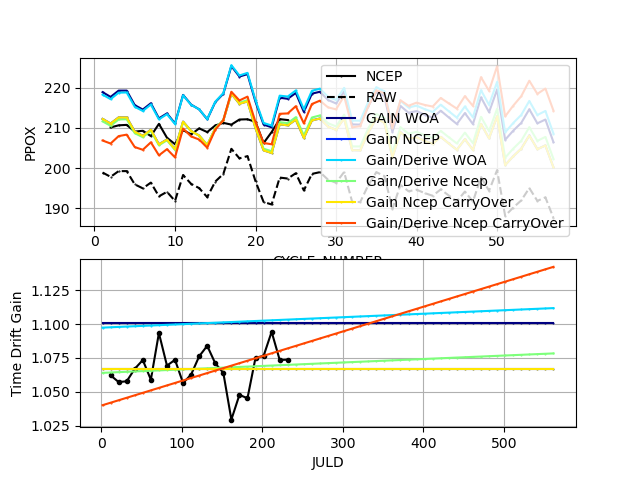

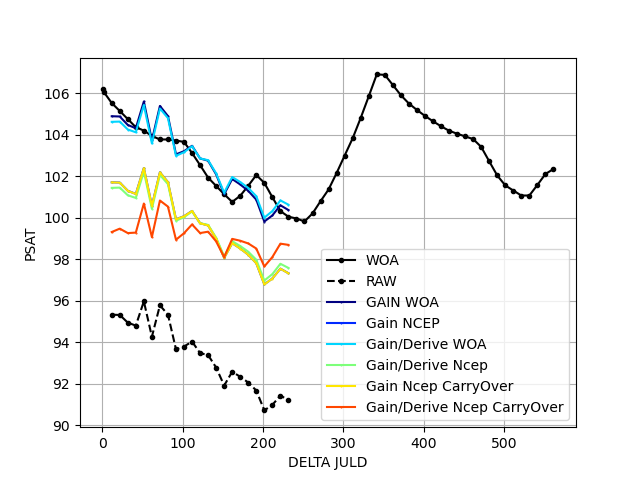

In [36]:
# Compare corrections
# User can change dict_corr.
# Example : dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP} compares Gain WOA Correction
# with Gain NCEP Correction.
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : params_Gain_NCEP_CarryOver,'Gain/Derive Ncep CarryOver' : params_Gain_Derive_NCEP_CarryOver}
breakpoint_list=[[]] * len(dict_corr)
_=plot_cmp_corr_NCEP(dict_corr,breakpoint_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_NCEP.png'))
_=plot_cmp_corr_WOA(dict_corr, breakpoint_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_PSATWOA.png'))


# Piece wise Correction
- If the user chooses a piece correction, that means there is a drift.
- If the user wants a piece correction only with a simple gain, then he can process the soft with different first_cycle_to_use/last_cycle_to_use
- When pieces :
    - We use polyfit to estimate the straight line by pieces.
    - We estimate the gain and drift so that the corrected data coresponds to this straight line.


## Number of pieces defined by the user

### WOA

In [37]:
# Number of piece to be defined by the user
nb_segment_WOA = 2

Breakpoints (X) : [ 11.53263889  53.61327902 231.53125   ]
Breaks : [ 11.53263889  53.61327902 231.53125   ]
Slopes : [-3.59906997e-04  7.24824519e-05]
Intercepts : [1.11274095 1.08955913]


Correction WOA : Piece 1

Gain/Drift WOA calculated directly from PWLF module : 1.1127409509327486,-11.80562770500704
Gain/Drift WOA calculated with curve_fit : [  1.11274095 -11.80562771] error : [0.00536901 5.09747973]


Correction WOA : Piece 2

Gain/Drift WOA calculated directly from PWLF module : 1.0895591347510036,2.42814676943738
Gain/Drift WOA calculated with curve_fit : [1.08955913 2.42814677] error : [0.00660885 1.42435924]


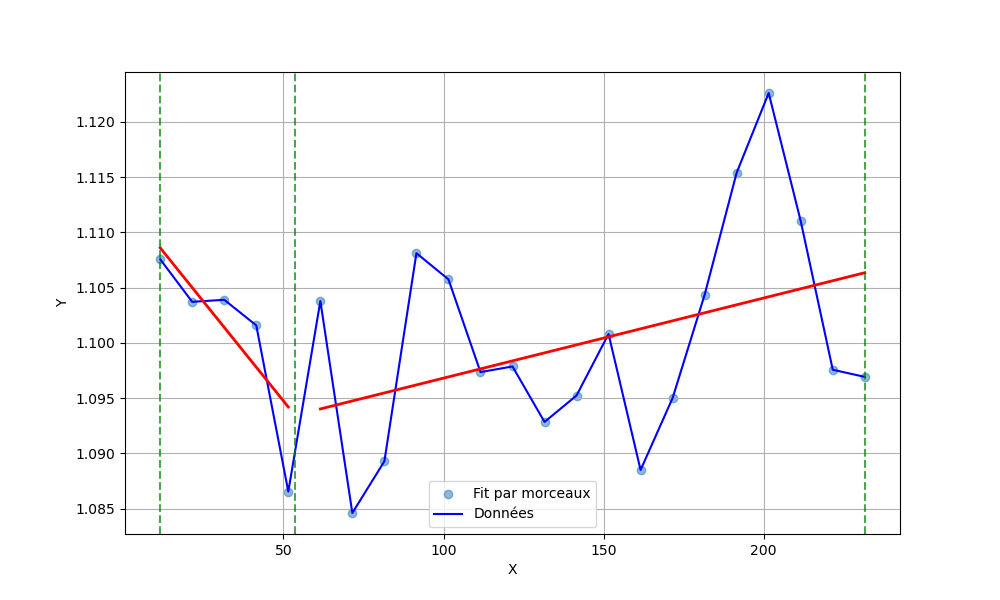

In [38]:
params_morceaux_Gain_Derive_WOA = []
perr_morceaux_Gain_Derive_WOA = []
bid = ppox_WOA_mean/ppox_ARGO_mean
mask = ~np.isnan(bid)
y_noisy = bid[mask]
x = delta_T_WOA[mask]


model = pwlf.PiecewiseLinFit(x, y_noisy)
model.fit(nb_segment_WOA)
breakpoints = model.fit_breaks  # Coordonnées X des breakpoints
print(f"Breakpoints (X) : {breakpoints}")
x_pred = delta_T_WOA
y_pred = model.predict(x_pred)

plt.figure(figsize=(10,6))
plt.scatter(x, y_noisy, label="Données bruitées", alpha=0.5)
plt.plot(x,y_noisy,'-b')
breaks_WOA = model.fit_breaks
slopes = model.slopes
intercepts = model.intercepts

print("Breaks :", model.fit_breaks)
print("Slopes :", model.slopes)
print("Intercepts :", model.intercepts)
# formule  = Y = Slopes * X + Intercept

for i in range(nb_segment_WOA):
    print(f"\n\nCorrection WOA : Piece {i+1}\n")
    x0, x1 = breaks_WOA[i], breaks_WOA[i+1]
    mask = (delta_T_WOA >=x0) & (delta_T_WOA<=x1)
    xs = delta_T_WOA[mask]            
    ys = slopes[i] * xs + intercepts[i]
    plt.plot(xs, ys, color="red", lw=2)
    slope_woa = intercepts[i]
    drift_woa = slopes[i] * 36500/slope_woa
    print(f"Gain/Drift WOA calculated directly from PWLF module : {slope_woa},{drift_woa}")

    # La version de pwlf ne permet pas d'avoir acces aux erreurs sur l'estimation de slope et intercept.
    # cov = model.calc_covariance() plante.
    # Pour contourner cela et obtenir une erreur, on passe par curve_fit.
    bid = ppox_WOA_mean/ppox_ARGO_mean
    popt, pcov = curve_fit(model_AXplusB, xs, bid[mask], p0=[1,0],nan_policy='omit')
    perr_bid_WOA = np.sqrt(np.diag(pcov))
    #print(f"popt : {popt}, error : {perr_bid_WOA}")

    perr_bid_WOA_final = perr_bid_WOA.copy()
    perr_bid_WOA_final[0] = perr_bid_WOA[1] # The error on slope_woa = error on intercepts (because slope_woa = intercepts[i])
    perr_bid_WOA_final[1] = 36500 * np.sqrt( (perr_bid_WOA[0] / intercepts[i])**2 + ((slopes[i] * perr_bid_WOA[1]) / (intercepts[i]**2))**2 ) # because drift_woa = slopes[i] * 36500/slope_woa

    initial_guess = [1, 0]  # Valeurs initiales pour G et D 
    mask = (delta_T_WOA >=x0) & (delta_T_WOA<=x1)
    xs = delta_T_WOA[mask]            # dense sur le segment
    ys = slopes[i] * xs + intercepts[i]
    var1_seg = ppox_ARGO_mean[mask]
    delta_T_seg = delta_T_WOA[mask]
    #val_bid1,covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ppox_WOA_mean[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
    #print(f"val_bid WOA1: {val_bid1}")
    val_bid,covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ys, p0=initial_guess,nan_policy='omit',full_output=True)
    #perr_bid = np.sqrt(np.diag(covariance))
    perr_morceaux_Gain_Derive_WOA.append(perr_bid_WOA_final)
    print(f"Gain/Drift WOA calculated with curve_fit : {val_bid} error : {perr_bid_WOA_final}")
    params_morceaux_Gain_Derive_WOA.append(val_bid)   
        
    
for b in breaks_WOA:
    plt.axvline(b, color="green", ls="--", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Fit par morceaux", "Données"])
plt.grid(True)
plt.show()

### NCEP

In [39]:
nb_segment_NCEP = 2

Breakpoints (X) : [ 11.5493287  177.23939812 231.5481713 ]
Breaks : [ 11.5493287  177.23939812 231.5481713 ]
Slopes : [-5.69290588e-05  4.43390580e-04]
Intercepts : [1.07010801 0.98143165]


Correction NCEP : Piece 1

Gain/Drift NCEP calculated directly from PWLF module : 1.0701080063287027,-1.9417765628603925
Gain/Drift NCEP calculated with curve_fit : [ 1.07010801 -1.94177656] error : [0.00746266 2.45155415]
Piece 1 lasts more than 90 days : CarryOver Estimation
Gain/Drift NCEP CarryOver calculated with curve_fit : [ 1.06859478e+00  1.48489091e-08 -1.59835398e+00] error : [0.00848507 0.03838198 2.62874466]


Correction NCEP : Piece 2

Gain/Drift NCEP calculated directly from PWLF module : 0.9814316546861936,16.489947202627764
Gain/Drift NCEP calculated with curve_fit : [ 0.98143165 16.4899472 ] error : [ 0.07427565 13.38685543]
Piece 2 lasts less than 90 days : No CarryOver Estimation
Gain/Drift NCEP calculated with curve_fit : [ 0.98143165 16.4899472 ] error : [ 0.07427565 13.386855

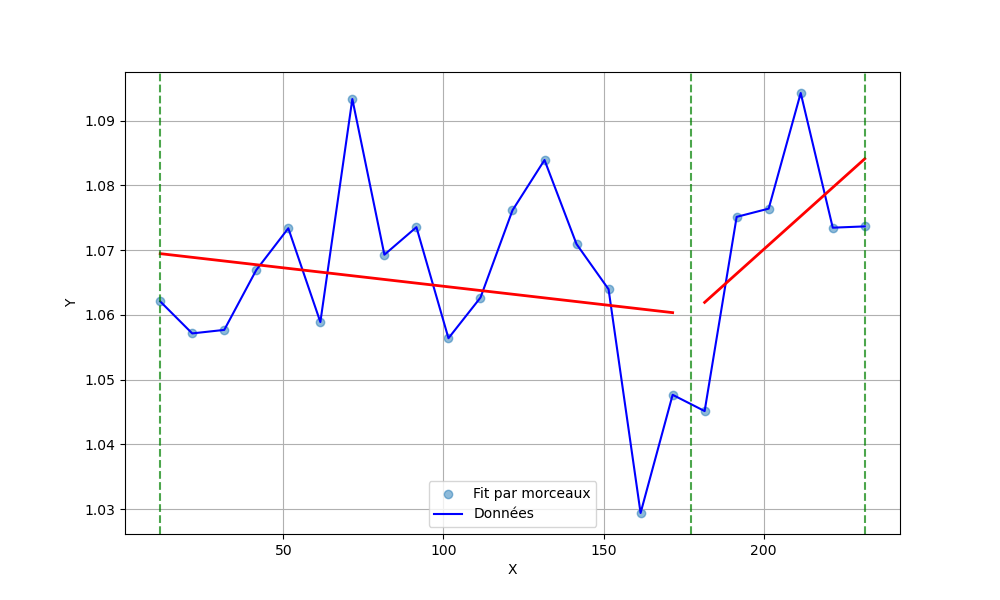

In [40]:
params_morceaux_Gain_Derive_NCEP = []
params_morceaux_Gain_Derive_CarryOver = []
perr_morceaux_Gain_Derive_NCEP = []
perr_morceaux_Gain_Derive_CarryOver = []

bid = NCEP_PPOX/PPOX1
mask = np.isfinite(bid)
y_noisy = bid[mask]
x = delta_T_NCEP[mask]

model = pwlf.PiecewiseLinFit(x, y_noisy)
model.fit(nb_segment_NCEP)

breakpoints = model.fit_breaks  # Coordonnées X des breakpoints
print(f"Breakpoints (X) : {breakpoints}")
x_pred = delta_T_NCEP
y_pred = model.predict(x_pred)


plt.figure(figsize=(10,6))
plt.scatter(x, y_noisy, label="Données bruitées", alpha=0.5)
plt.plot(x,y_noisy,'-b')
breaks_NCEP = model.fit_breaks
slopes = model.slopes
intercepts = model.intercepts

print("Breaks :", model.fit_breaks)
print("Slopes :", model.slopes)
print("Intercepts :", model.intercepts)
# formule  = Y = Slopes * X + Intercept


nb_day_carryover = 90
for i in range(nb_segment_NCEP):
    print(f"\n\nCorrection NCEP : Piece {i+1}\n")
    x0, x1 = breaks_NCEP[i], breaks_NCEP[i+1]
    mask = (delta_T_NCEP >=x0) & (delta_T_NCEP<=x1)
    xs = delta_T_NCEP[mask]            # dense sur le segment
    ys = slopes[i] * xs + intercepts[i]
    plt.plot(xs, ys, color="red", lw=2)
    slope_ncep = intercepts[i]
    drift_ncep = slopes[i] * 36500/slope_ncep
    print(f"Gain/Drift NCEP calculated directly from PWLF module : {slope_ncep},{drift_ncep}")


    # La version de pwlf ne permet pas d'avoir acces aux erreurs sur l'estimation de slope et intercept.
    # cov = model.calc_covariance() plante.
    # Pour contourner cela et obtenir une erreur, on passe par curve_fit.
    bid = NCEP_PPOX/dsair['PPOX_DOXY']
    popt, pcov = curve_fit(model_AXplusB, xs, bid[mask], p0=[1,0],nan_policy='omit')
    perr_bid_NCEP = np.sqrt(np.diag(pcov))
    
    var1_seg = PPOX1[mask]
    var2_seg = PPOX2[mask]
    delta_T_seg = delta_T_NCEP[mask]
    initial_guess = [1, 0]  # Valeurs initiales pour G et D 
    #val_bid1,covariance,info,mesg,ier= curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], NCEP_PPOX[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
    #print(f"val_bid NCEP 1: {val_bid1}")
    #print(f"Erreur Gain/Derive NCEP : {np.sqrt(np.diag(covariance))}")

    val_bid_NCEP,covariance,info,mesg,ier= curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ys, p0=initial_guess,nan_policy='omit',full_output=True)
    # perr_bid_NCEP = np.sqrt(np.diag(covariance)) # Les erreurs sont mal estimees (infimes voire nulles).
    
    #
    # Calcul de l'erreur sur slope et drift final.
    #
    perr_bid_NCEP_final = perr_bid_NCEP.copy()
    perr_bid_NCEP_final[0] = perr_bid_NCEP[1]
    perr_bid_NCEP_final[1] = 36500 * np.sqrt( (perr_bid_NCEP[0] / intercepts[i])**2 + ((slopes[i] * perr_bid_NCEP[1]) / (intercepts[i]**2))**2 )
    perr_morceaux_Gain_Derive_NCEP.append(perr_bid_NCEP_final)
    print(f"Gain/Drift NCEP calculated with curve_fit : {val_bid_NCEP} error : {perr_bid_NCEP_final}")



    params_morceaux_Gain_Derive_NCEP.append(val_bid_NCEP)

    if (breaks_NCEP[i+1]-breaks_NCEP[i]>nb_day_carryover):
        print(f"Piece {i+1} lasts more than {nb_day_carryover} days : CarryOver Estimation")
        initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
        val_bid_NCEP_CarryOver, covariance,info,mesg,ier = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],NCEP_PPOX[mask],p0=initial_guess,nan_policy='omit',full_output=True)
        #val_bid2, covariance,info,mesg,ier = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],ys*dsair['PPOX_DOXY'][mask],p0=initial_guess,nan_policy='omit',full_output=True)
        #print(f"val_bid NCEP CarryOver2: {val_bid2}")
        params_morceaux_Gain_Derive_CarryOver.append(val_bid_NCEP_CarryOver)  
        perr_bid_CarryOver = np.sqrt(np.diag(covariance))
        perr_morceaux_Gain_Derive_CarryOver.append(perr_bid_CarryOver)
        print(f"Gain/Drift NCEP CarryOver calculated with curve_fit : {val_bid_NCEP_CarryOver} error : {perr_bid_CarryOver}")


    else:
        print(f"Piece {i+1} lasts less than {nb_day_carryover} days : No CarryOver Estimation")
        print(f"Gain/Drift NCEP calculated with curve_fit : {val_bid_NCEP} error : {perr_bid_NCEP_final}")
        val_bid = np.array([val_bid_NCEP[0],0,val_bid_NCEP[1]])
        perr_bid = np.array([perr_bid_NCEP_final[0],0,perr_bid_NCEP_final[1]])
        params_morceaux_Gain_Derive_CarryOver.append(val_bid)   
        perr_morceaux_Gain_Derive_CarryOver.append(perr_bid)

        
    
for b in breaks_NCEP:
    plt.axvline(b, color="green", ls="--", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Fit par morceaux", "Données"])
plt.grid(True)
plt.show()

### Results creation

In [41]:
params_morceaux_Gain_Derive_NCEP = np.array(params_morceaux_Gain_Derive_NCEP)
params_morceaux_Gain_Derive_CarryOver = np.array(params_morceaux_Gain_Derive_CarryOver)
params_morceaux_Gain_Derive_CarryOver = params_morceaux_Gain_Derive_CarryOver[:, [0, 2]]
params_morceaux_Gain_Derive_WOA = np.array(params_morceaux_Gain_Derive_WOA)

perr_morceaux_Gain_Derive_NCEP = np.array(perr_morceaux_Gain_Derive_NCEP)
perr_morceaux_Gain_Derive_CarryOver = np.array(perr_morceaux_Gain_Derive_CarryOver)
perr_morceaux_Gain_Derive_CarryOver = perr_morceaux_Gain_Derive_CarryOver[:, [0, 2]]
perr_morceaux_Gain_Derive_WOA = np.array(perr_morceaux_Gain_Derive_WOA)

In [42]:
dict_corr = {'Gain/Derive Piece WOA' : np.stack((params_morceaux_Gain_Derive_WOA, perr_morceaux_Gain_Derive_WOA), axis=0),
             'Gain/Derive Piece Ncep' : np.stack((params_morceaux_Gain_Derive_NCEP,perr_morceaux_Gain_Derive_NCEP),axis=0),'Gain/Derive Ncep Piece CarryOver' : np.stack((params_morceaux_Gain_Derive_CarryOver,perr_morceaux_Gain_Derive_CarryOver),axis=0),
            'Gain/Derive Ncep':np.stack((params_Gain_Derive_NCEP,perr_Gain_Derive_NCEP),axis=0),'Gain NCEP':np.stack((params_Gain_NCEP,perr_Gain_NCEP),axis=0),
            'Gain/Derive NCEP CarryOver':np.stack((params_Gain_Derive_NCEP_CarryOver,perr_Gain_Derive_NCEP_CarryOver),axis=0)}
write_param_results(dict_corr,num_float)


6902982
Gain/Derive Piece WOA
Piece 1  : Gain/Drift/Pressure 1.1127/-11.8056/0.0000 with error 0.0054/5.0975/0.0000
Piece 2  : Gain/Drift/Pressure 1.0896/2.4281/0.0000 with error 0.0066/1.4244/0.0000
Gain/Derive Piece Ncep
Piece 1  : Gain/Drift/Pressure 1.0701/-1.9418/0.0000 with error 0.0075/2.4516/0.0000
Piece 2  : Gain/Drift/Pressure 0.9814/16.4899/0.0000 with error 0.0743/13.3869/0.0000
Gain/Derive Ncep Piece CarryOver
Piece 1  : Gain/Drift/Pressure 1.0686/-1.5984/0.0000 with error 0.0085/2.6287/0.0000
Piece 2  : Gain/Drift/Pressure 0.9814/16.4899/0.0000 with error 0.0743/13.3869/0.0000
Gain/Derive Ncep
Gain/Drift/Pressure 1.0639/0.8788/0.0000 with error 0.0066/1.6289/0.0000
Gain NCEP
Gain/Drift/Pressure 1.0670/0.0000/0.0000 with error 0.0031/0.0000/0.0000
Gain/Derive NCEP CarryOver
Gain/Drift/Pressure 1.0397/6.4086/0.0000 with error 0.0094/2.4371/0.0000


### Plots

GAIN WOA
Number of pieces : 1
[1.10044407]
Gain NCEP
Number of pieces : 1
[1.06701353]
Gain/Derive WOA
Number of pieces : 1
[1.09731569 0.85625171]
Gain/Derive Ncep
Number of pieces : 1
[1.06390013 0.8787962 ]
Gain Ncep CarryOver
Number of pieces : 1
[1.06697343]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.03974913 6.40864039]
GAIN WOA
Number of pieces : 1
[1.10044407]
Gain NCEP
Number of pieces : 1
[1.06701353]
Gain/Derive WOA
Number of pieces : 1
[1.09731569 0.85625171]
Gain/Derive Ncep
Number of pieces : 1
[1.06390013 0.8787962 ]
Gain Ncep CarryOver
Number of pieces : 1
[1.06697343]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.03974913 6.40864039]


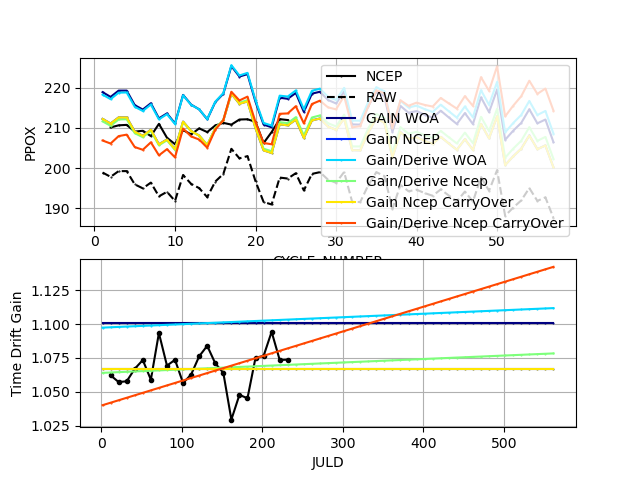

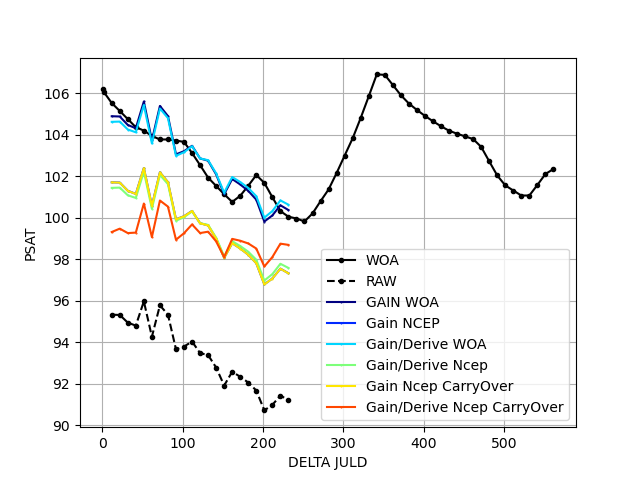

In [43]:
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : params_Gain_NCEP_CarryOver,'Gain/Derive Ncep CarryOver' : params_Gain_Derive_NCEP_CarryOver}
breakpoint_list=[[]] * len(dict_corr)
_=plot_cmp_corr_NCEP(dict_corr,breakpoint_list,dsair,NCEP_PPOX,delta_T_NCEP)
_=plot_cmp_corr_WOA(dict_corr, breakpoint_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)

Gain/Derive Piece WOA
Number of pieces : 2
[  1.11274095 -11.80562771]
[1.08955913 2.42814677]
Gain/Derive Piece Ncep
Number of pieces : 2
[ 1.07010801 -1.94177656]
[ 0.98143165 16.4899472 ]
Gain/Derive Ncep Piece CarryOver
Number of pieces : 2
[ 1.06859478 -1.59835398]
[ 0.98143165 16.4899472 ]
Gain/Derive Piece WOA
Number of pieces : 2
[  1.11274095 -11.80562771]
[1.08955913 2.42814677]
Gain/Derive Piece Ncep
Number of pieces : 2
[ 1.07010801 -1.94177656]
[ 0.98143165 16.4899472 ]
Gain/Derive Ncep Piece CarryOver
Number of pieces : 2
[ 1.06859478 -1.59835398]
[ 0.98143165 16.4899472 ]


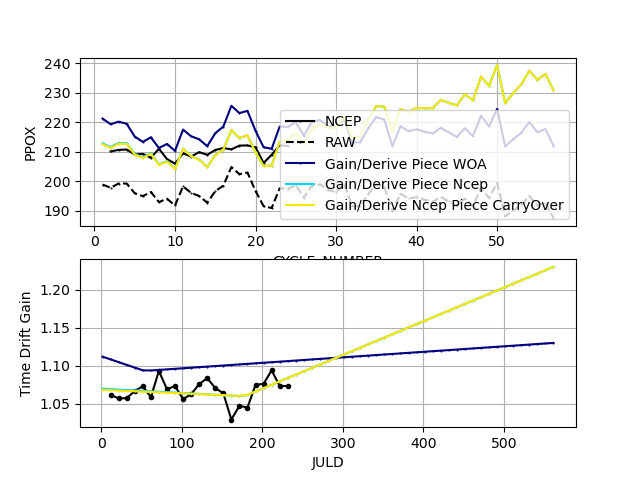

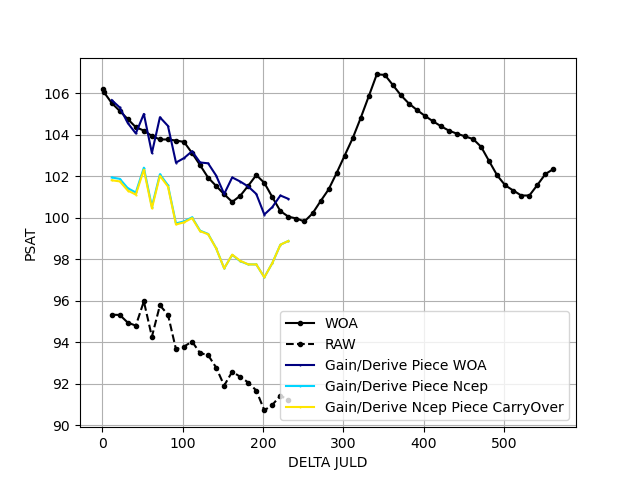

In [44]:
dict_corr = {'Gain/Derive Piece WOA' : params_morceaux_Gain_Derive_WOA,
             'Gain/Derive Piece Ncep' : params_morceaux_Gain_Derive_NCEP,'Gain/Derive Ncep Piece CarryOver' : params_morceaux_Gain_Derive_CarryOver}
breaks_WOA_plot = breaks_WOA.copy()
breaks_NCEP_plot = breaks_NCEP.copy()
breaks_NCEP_plot[-1]=np.max([delta_T_WOA[-1],delta_T_NCEP[-1]])
breaks_WOA_plot[-1]=np.max([delta_T_WOA[-1],delta_T_NCEP[-1]])
breaks_NCEP_plot[0]=np.min([delta_T_WOA[0],delta_T_NCEP[0]])
breaks_WOA_plot[0]=np.min([delta_T_WOA[0],delta_T_NCEP[0]])
breakpoint_list=[breaks_WOA_plot,breaks_NCEP_plot,breaks_NCEP_plot]
_=plot_cmp_corr_NCEP(dict_corr,breakpoint_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_NCEP.png'))
_=plot_cmp_corr_WOA(dict_corr, breakpoint_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_PSATWOA.png'))

### The user must decide which correction to apply

In [45]:
# Which correction to keep/apply
# Here, the user must decide which correction to keep to estimate a supplement gain with CTD.
# 
# corr_to_keep = 1 ==> WOA GAIN
# corr_to_keep = 2 ==> WOA Gain/Drift
# corr_to_keep = 3 ==> NCEP Gain without CarryOver
# corr_to_keep = 4 ==> NCEP Gain with CarryOver
# corr_to_keep = 5 ==> NCEP Gain/Drift without CarryOver
# corr_to_keep = 6 ==> NCEP Gain/Drift with CarryOver

breaks_to_keep = np.array([min(delta_T_Sprof),max(delta_T_Sprof)])
corr_to_keep = 4 #6
match corr_to_keep:
    case 1:
        params_to_keep = copy.deepcopy(params_Gain_WOA)
        comment_corr = 'Correction with a WOA Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_WOA)
        nb_param = 1
    case 2:
        params_to_keep = copy.deepcopy(params_Gain_Derive_WOA)
        comment_corr = 'Correction with a WOA Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_WOA)
        nb_param = 2
    case 3:
        params_to_keep = copy.deepcopy(params_Gain_NCEP)
        comment_corr = 'Correction with a NCEP Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_NCEP)
        nb_param = 1
    case 4:
        params_to_keep = copy.deepcopy(params_Gain_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_NCEP_CarryOver)
        nb_param = 1
    case 5:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP)
        comment_corr = 'Correction with a NCEP Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_NCEP)
        nb_param = 2
    case 6:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_NCEP_CarryOver)
        nb_param = 2
    
    case 7 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_NCEP)
        comment_corr = 'Correction by piece with a NCEP  Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_NCEP
        nb_param = 2
        breaks_to_keep = breaks_NCEP

    case 8 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_CarryOver)
        comment_corr = 'Correction by piece with a NCEP CarryOver Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_CarryOver
        nb_param = 2
        breaks_to_keep = breaks_NCEP


    case 9 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_WOA)
        comment_corr = 'Correction with a WOA Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_WOA
        nb_param = 2
        breaks_to_keep = breaks_WOA

nb_segment = len(breaks_to_keep)-1

print(f'breakpoint : {breaks_to_keep}')
breaks_to_keep[0] = min(delta_T_Sprof)
breaks_to_keep[-1] = max(delta_T_Sprof)

print(comment_corr)
print(f'Correction used :  {params_to_keep}')
print(f'Error on correction : {perr_to_keep}')
print(f'Final breakpoint : {breaks_to_keep}')
print(f'nb_piece : {nb_segment}')

breakpoint : [9.51388889e-02 5.61531250e+02]
Correction with a NCEP CarryOver Gain
Correction used :  [1.06697343]
Error on correction : [0.003251]
Final breakpoint : [9.51388889e-02 5.61531250e+02]
nb_piece : 1


### Supplement gain estimation from CTD
- We can estimate the gain from PPOX or DOXY. It's the same only if offset = 0
- The user can indicate several CTD/cycles comparisons.
- The Gain is estimated by combining all the datas
- The Gain is estimated on CTD interpolated on theta ARGO.

param_ok : [1.06697343]
We use Adjusted Data for CTD/cycle comparaison
[1.0311821] [0.00107451]
[1.03659312] [0.00096853]
Supplement Gain from CTD (without effect pressure) :  1.0312


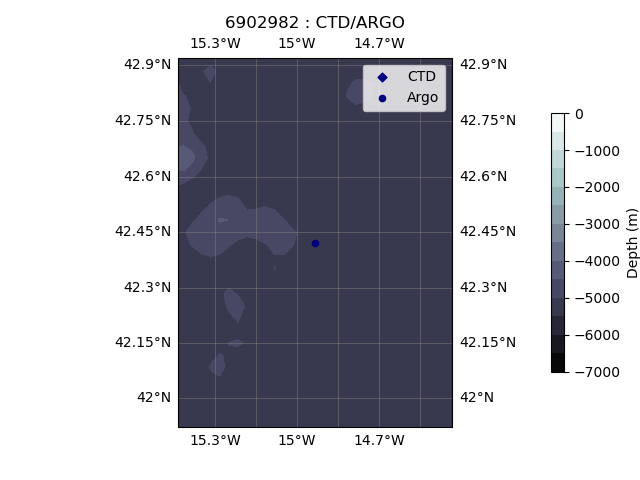

/Users/chemon/miniconda3/envs/locodox_conda_forge/lib/python3.10/site-packages/ipympl/backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


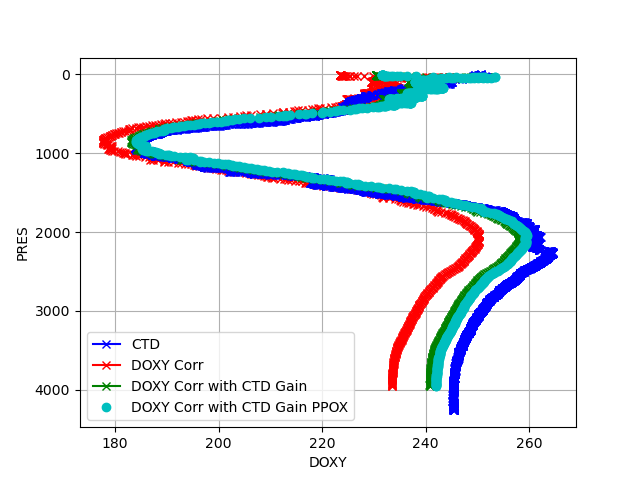

In [46]:
# We estimate a supplement Gain from the CTD without pressure effect.
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
perr_Gain_CTD = np.array([0])
ppox_cruise_tot = np.array([])
doxy_cruise_tot = np.array([])
ppox_cycle_corr_tot = np.array([])
doxy_cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])


# Compare ARGO Profil  with  CTD. We compare OXYGEN directly
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        _=plot_CTD_Argo_Pos(ds_argo_Sprof, ds_bathy,depths,extend_lon_lat,rep_ctd,fic_ctd,num_ctd,num_cycle)
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_CTD_argo.png'))

        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        
        delta_T_Sprof_en_cours = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof_en_cours,(1,len(ds_cycle['N_LEVELS'])))

        if nb_segment>1:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof_en_cours)
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep
            

        print(f'param_ok : {params_ok}')

        var_bid = ['PSAL','TEMP','PRES']
        info_nok = 0
        str_chaine_to_use = str_chaine
        if which_var==3:
            for var_en_cours in var_bid:
                var_name = var_en_cours + str_chaine
                if var_name in ds_cycle:
                    if np.all(np.isnan(ds_cycle[var_name].values)):
                        print(f" {var_name}: exists, but all NaN.")
                        info_nok = 1     
                else:
                    print(f" {var_name} doesn't exist")
                    info_nok = 1
            if info_nok==1:
                str_chaine_to_use = ''

        if str_chaine_to_use=='':
            print(f"We use RAW Data for CTD/cycle comparaison")
        else:
            print(f"We use Adjusted Data for CTD/cycle comparaison")

           

        ana_dens_cycle = sw.pden(ds_cycle['PSAL'+str_chaine_to_use],ds_cycle['TEMP'+str_chaine_to_use],ds_cycle['PRES'+str_chaine_to_use],0)
        O2_cycle_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens_cycle[0])
        ppox_cycle = O2ctoO2p(O2_cycle_umolL,ds_cycle['TEMP'+str_chaine_to_use].isel(N_PROF=0),ds_cycle['PSAL'+str_chaine_to_use].isel(N_PROF=0),ds_cycle['PRES'+str_chaine_to_use].isel(N_PROF=0)) 
        # Apply Initial Correction (from NCEP or WOA)
        if nb_param == 1:
            ppox_cycle_corr = model_Gain(ppox_cycle,*params_ok)
            doxy_cycle_corr = model_Gain(ds_cycle['DOXY'],*params_ok)
        else:
            ppox_cycle_corr = model_Gain_Derive([ppox_cycle,tab_delta_T],*params_ok)
            doxy_cycle_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_ok)

        # We concatenate all cycles
        doxy_cycle_corr_tot = np.concatenate((doxy_cycle_corr_tot,doxy_cycle_corr),axis=None)
        ppox_cycle_corr_tot = np.concatenate((ppox_cycle_corr_tot,ppox_cycle_corr),axis=None)


        # Compute ARGO and CTD theta.
        psal_cycle = ds_cycle['PSAL'+str_chaine_to_use].values
        pres_cycle = ds_cycle['PRES'+str_chaine_to_use].values 
        temp_cycle = ds_cycle['TEMP'+str_chaine_to_use].values
        theta_cycle = sw.ptmp(psal_cycle,temp_cycle,pres_cycle,0)

        # PPOX CTD
        ana_dens_cruise = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_cruise_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens_cruise[0])
        ppox_cruise = O2ctoO2p(O2_cruise_umolL,ds_cruise['TEMP'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0)) 
        # Interp CTD on ARGO pressure
        #ppox_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        #doxy_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0)) 
        #psal_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0))
        #temp_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['TEMP'].isel(N_PROF=0))
        #pres_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0))
        #ppox_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        #theta_cruise = sw.ptmp(psal_cruise_interp,temp_cruise_interp,pres_cruise_interp,0)
        # Interp CTD DOXY on ARGO theta
        #oxy_cruise_interp_on_theta, pres_cruise_interp_on_theta = interp_climatology(
        #    np.transpose(doxy_cruise_interp), np.transpose(theta_cruise), np.transpose(pres_cruise_interp), doxy_cycle_corr.transpose(), np.transpose(theta_cycle), np.transpose(pres_cycle))

        # Interp CTD on theta Float (interp_climatology_float from first version from pyowc)
        theta_cruise = sw.ptmp(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        oxy_cruise_interp_on_theta, pres_cruise_interp_on_theta = interp_climatology_float(
            ds_cruise['OXYK'].transpose(), np.transpose(theta_cruise),ds_cruise['PRES'].transpose(), doxy_cycle_corr[0,:], theta_cycle[0,:], pres_cycle[0,:])
        oxy_cruise_interp_on_theta = np.transpose(oxy_cruise_interp_on_theta)
        pres_cruise_interp_on_theta = np.transpose(pres_cruise_interp_on_theta)
        ppox_cruise_interp_on_theta, pres_cruise_interp_on_theta_bid = interp_climatology_float(
            ppox_cruise.transpose(), np.transpose(theta_cruise),ds_cruise['PRES'].transpose(), ppox_cycle_corr[0,:], theta_cycle[0,:], pres_cycle[0,:])
        ppox_cruise_interp_on_theta = np.transpose(ppox_cruise_interp_on_theta)


        diff_pres = np.abs(pres_cruise_interp_on_theta-pres_cycle)
        # If pres_cruise_interp_on_theta is too far from intial pressure ==> NaN
        isbad = diff_pres[0] > 50
        oxy_cruise_interp_on_theta[0][isbad]=np.NaN
        ppox_cruise_interp_on_theta[0][isbad]=np.NaN

        ppox_cruise_tot = np.concatenate((ppox_cruise_tot,ppox_cruise_interp_on_theta),axis=None)
        doxy_cruise_tot = np.concatenate((doxy_cruise_tot,oxy_cruise_interp_on_theta),axis=None)
        

        ds_cruise.close()
        ds_cycle.close()
 
    
    # Solution without pressure correction
    # CTD Gain estimation on all cycles/CTDs
    initial_guess = 0
    params_Gain_CTD_V2, covariance = curve_fit(model_Gain, ppox_cycle_corr_tot, ppox_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD_V2 = np.sqrt(np.diag(covariance))

    params_Gain_CTD, covariance = curve_fit(model_Gain, doxy_cycle_corr_tot, doxy_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD = np.sqrt(np.diag(covariance))
    
    print(params_Gain_CTD,perr_Gain_CTD)
    print(params_Gain_CTD_V2,perr_Gain_CTD_V2)

    print("Supplement Gain from CTD (without effect pressure) : ",",".join(f"{val:.4f}" for val in params_Gain_CTD))

    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        plt.figure()
        h2 = plt.plot(doxy_cycle_corr,ds_cycle['PRES'],'-xr')
        h1 = plt.plot(ds_cruise['OXYK'],ds_cruise['PRES'],'-xb')
        h3 = plt.plot(doxy_cycle_corr*params_Gain_CTD,ds_cycle['PRES'],'-xg')
        h4 = plt.plot(doxy_cycle_corr*params_Gain_CTD_V2,ds_cycle['PRES'],'oc')

        plt.grid()
        plt.gca().invert_yaxis()
        plt.xlabel('DOXY')
        plt.ylabel('PRES')
        plt.legend([h1[0],h2[0],h3[0],h4[0]],['CTD','DOXY Corr','DOXY Corr with CTD Gain','DOXY Corr with CTD Gain PPOX'])
        

# Supplement Gain and effect pressure estimation from CTD
## We estimate the effect pressure and the gain simultaneously
- The pressure effect must be calculated on DOXY only. <br>
  The pressure effect is applied on the DOXY (not on PPOX)
- The pressure effect is calculated on theta levels.

## Remarque
- When “undoing” the pressure effect, PRES and TEMP are used (not PRES_ADJUSTED and TEMP_ADJUSTED). <br>
  This is because PRES and TEMP are used during ARGO decoding.  <br>
- When correcting BD files, TEMP and PRES (Raw Data) are also used to undo the initial pressure effect <br>
  and apply the new pressure effect..
- The user can use several CTD/cycle comparison. There is one (Gain/pressure effect) for each. <br>
  Attention : the result given is for the last (CTD/cycle) comparison. The user must adapt to choose the best estimation.

[1.06697343]
param_ok : [1.06697343]
We use Adjusted Data for CTD/cycle comparaison
Pressure effect Estimation
CTD pressure effect estimated with pressure effect : 0.053517 with error 0.000728
CTD Gain estimated with pressure effect : 1.022769 with error 0.001630
[1.0227687] [0.05351732]


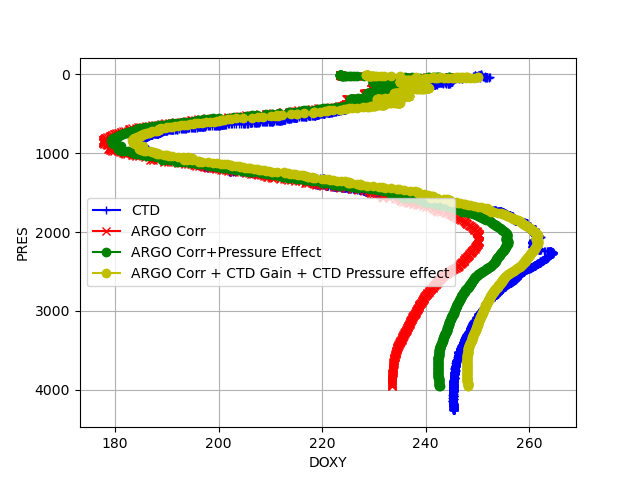

In [47]:
from scipy.interpolate import interp1d

# We estimate a pressure effect by using potential temperature.
# Init Pressure correction (0 by default) and a supplement gain from CTD (1 by default)
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])
perr_pressure = np.array([0,0])

print(params_to_keep)
# Pressure effect estimation.
# We compare ARGO O2 with CTD O2.
# According to V. Thierry, we must estimate a Gain and a pressure effect.
# Estimate only a pressure effect seems to be incorrect.
# We do thatfrom the 'first' correction.

if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        delta_T_Sprof_en_cours = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof_en_cours,(1,len(ds_cycle['N_LEVELS'])))

        if nb_segment>1:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof_en_cours)
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep
            

        print(f'param_ok : {params_ok}')


        var_bid = ['PSAL','TEMP','PRES']
        info_nok = 0
        str_chaine_to_use = str_chaine
        if which_var==3:
            for var_en_cours in var_bid:
                var_name = var_en_cours + str_chaine
                if var_name in ds_cycle:
                    if np.all(np.isnan(ds_cycle[var_name].values)):
                        print(f" {var_name}: exists, but all NaN.")
                        info_nok = 1     
                else:
                    print(f" {var_name} doesn't exist")
                    info_nok = 1
            if info_nok==1:
                str_chaine_to_use = ''

        if str_chaine_to_use=='':
            print(f"We use RAW Data for CTD/cycle comparaison")
        else:
            print(f"We use Adjusted Data for CTD/cycle comparaison")

        ana_dens_cruise = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_cruise_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens_cruise[0])
        ppox_cruise = O2ctoO2p(O2_cruise_umolL,ds_cruise['TEMP'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0)) 

        ana_dens_cycle = sw.pden(ds_cycle['PSAL'+str_chaine_to_use],ds_cycle['TEMP'+str_chaine_to_use],ds_cycle['PRES'+str_chaine_to_use],0)
        O2_cycle_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens_cycle[0])
        ppox_cycle = O2ctoO2p(O2_cycle_umolL,ds_cycle['TEMP'+str_chaine_to_use].isel(N_PROF=0),ds_cycle['PSAL'+str_chaine_to_use].isel(N_PROF=0),ds_cycle['PRES'+str_chaine_to_use].isel(N_PROF=0)) 
        if nb_param == 1:
            ppox_cycle_corr = model_Gain(ppox_cycle,*params_ok)
            doxy_cycle_corr = model_Gain(ds_cycle['DOXY'],*params_ok)
        else:
            ppox_cycle_corr = model_Gain_Derive([ppox_cycle,tab_delta_T],*params_ok)
            doxy_cycle_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_ok)


        

        # Compute ARGO and CTD theta.
        # pres_corr_pres_cycle/temp_corr_pres_cycle : useful for pressure effect
        psal_cycle = ds_cycle['PSAL'+str_chaine_to_use].values
        pres_cycle = ds_cycle['PRES'+str_chaine_to_use].values 
        pres_corr_pres_cycle = ds_cycle['PRES'].values 
        temp_cycle = ds_cycle['TEMP'+str_chaine_to_use].values
        temp_corr_pres_cycle = ds_cycle['TEMP'].values
        theta_cycle = sw.ptmp(psal_cycle,temp_cycle,pres_cycle,0)

        # Interpolation CTD on ARGO Pressure
        #doxy_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))
        #psal_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0))
        #temp_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['TEMP'].isel(N_PROF=0))
        #pres_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0))
        #ppox_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        #theta_cruise = sw.ptmp(psal_cruise_interp,temp_cruise_interp,pres_cruise_interp,0)
        theta_cruise = sw.ptmp(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        oxy_cruise_interp_on_theta, pres_cruise_interp_on_theta = interp_climatology_float(
            ds_cruise['OXYK'].transpose(), np.transpose(theta_cruise),ds_cruise['PRES'].transpose(), doxy_cycle_corr[0,:], theta_cycle[0,:], pres_cycle[0,:])
        oxy_cruise_interp_on_theta = np.transpose(oxy_cruise_interp_on_theta)
        pres_cruise_interp_on_theta = np.transpose(pres_cruise_interp_on_theta)
        
        # interpolation CTD on ARGO_Theta
        #oxy_cruise_interp_on_theta_V2, pres_cruise_interp_on_theta_V2 = interp_climatology(
        #    ds_cruise['OXYK'].transpose(), np.transpose(theta_cruise),ds_cruise['PRES'].transpose(), doxy_cycle_corr.transpose(), np.transpose(theta_cycle), np.transpose(pres_cycle))
        #oxy_cruise_interp_on_theta_V2 = np.transpose(oxy_cruise_interp_on_theta_V2)
        #pres_cruise_interp_on_theta_V2 = np.transpose(pres_cruise_interp_on_theta_V2)
        #ppox_cruise_interp_on_theta, pres_cruise_interp_on_theta_bid = interp_climatology(
        #    np.transpose(ppox_cruise_interp), np.transpose(theta_cruise), np.transpose(pres_cruise_interp), doxy_cycle_corr.transpose(), np.transpose(theta_cycle), np.transpose(pres_cycle))
        #ppox_cruise_interp_on_theta = np.transpose(ppox_cruise_interp_on_theta)

        diff_pres = np.abs(pres_cruise_interp_on_theta-pres_cycle)
        # If pres_cruise_interp_on_theta is too far from intial pressure ==> NaN
        isbad = diff_pres[0] > 50
        oxy_cruise_interp_on_theta[0][isbad]=np.NaN
        ppox_cruise_interp_on_theta[0][isbad]=np.NaN
        
        
        # Keep data under a pressure threshold
        mask = pres_cycle[0] >= pressure_threshold
       
        print('Pressure effect Estimation')
        initial_guess = [1,0]   
        params_corr_pressure, covariance = curve_fit(lambda X, G, Gp: model_Gain_pres(X, G, Gp, pcoef2, pcoef3),
                       [doxy_cycle_corr[0][mask],pres_corr_pres_cycle[0][mask],temp_corr_pres_cycle[0][mask]], oxy_cruise_interp_on_theta[0][mask], p0=initial_guess,nan_policy='omit')
        perr_pressure = np.sqrt(np.diag(covariance))
        print(f'CTD pressure effect estimated with pressure effect : {params_corr_pressure[1]:.6f} with error {perr_pressure[1]:.6f}')
        print(f'CTD Gain estimated with pressure effect : {params_corr_pressure[0]:.6f} with error {perr_pressure[0]:.6f}')

        

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],ds_cruise['PRES'][0],'+-b')
        h2 = plt.plot(doxy_cycle_corr[0],ds_cycle['PRES'][0],'x-r')
        h3=plt.plot(doxy_cycle_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+ params_corr_pressure[1])*ds_cycle['PRES'][0]/1000),ds_cycle['PRES'][0],'o-g')  
        h4=plt.plot(doxy_cycle_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+params_corr_pressure[1])*ds_cycle['PRES'][0]/1000)*params_corr_pressure[0],ds_cycle['PRES'][0],'o-y')        
        plt.gca().invert_yaxis()
        plt.grid()
        _=plt.legend([h1[0],h2[0],h3[0], h4[0]],['CTD','ARGO Corr','ARGO Corr+Pressure Effect','ARGO Corr + CTD Gain + CTD Pressure effect'])
        plt.xlabel('DOXY')
        plt.ylabel('PRES')

        params_Gain_CTD_with_pressure = np.array([params_corr_pressure[0]])
        params_corr_pressure = np.array([params_corr_pressure[1]])
        print(params_Gain_CTD_with_pressure,params_corr_pressure)

        #initial_guess =[1]
        #params_Gain_CTD_CK, covariance = curve_fit(model_Gain, doxy_cycle_pour_pres, doxy_cruise_pour_pres, p0=initial_guess,nan_policy='omit')
        #print(params_Gain_CTD_CK)
        
        ds_cruise.close()
        ds_cycle.close()

## Error and correction creation
### Add 1 or 2 column of 0 in the error array (column for the error on drift if necessary and for the pressure effect)
###  Create 4 solutions and the associated error
- The initial one
- The initial one with a CTD gain
- The initial one with a pressure effect
- The initial one with a CTD gain and pressure effect

In [48]:
# Create error array with or without pressure effect.
print(perr_to_keep)
perr_final = perr_to_keep.copy()
derive_final = 0
if nb_param == 1:
    if nb_segment==1:
        perr_final = np.append(perr_final, 0) # error on drift
        perr_final = np.append(perr_final, 0) # error on pressure effect
    else: # On ne passe jamais la. Si plusieurs segments, alors on estime gain et derive, donc nb_param>1
        zeros_column = np.zeros((perr_final.shape[0], 2))  # Créer 2 colonne de zéros
        perr_final = np.hstack((perr_final, zeros_column)) 
else :
    if nb_segment==1:
        derive_final = params_to_keep[1]
        perr_final = np.append(perr_final, 0) # error on pressure effect
    else:
        zeros_column = np.zeros((perr_final.shape[0], 1))  # Créer une colonne de zéros
        perr_final = np.hstack((perr_final, zeros_column)) 
        derive_final = params_to_keep[:,1]

print(perr_to_keep)
print(perr_final)

[0.003251]
[0.003251]
[0.003251 0.       0.      ]


In [49]:
if nb_segment==1:
    corr_final_without_pressure_correction = np.array([params_to_keep[0],derive_final,params_no_corr_pressure[0]])
    corr_final_with_pressure_correction = np.array([params_to_keep[0],derive_final,params_corr_pressure[0]])
    corr_final_CTD_without_pressure_correction = np.array([params_Gain_CTD[0] * params_to_keep[0],derive_final,params_no_corr_pressure[0]])
    corr_final_CTD_with_pressure_correction = np.array([params_Gain_CTD_with_pressure[0] * params_to_keep[0],derive_final,params_corr_pressure[0]])
    perr_final_pressure = perr_final.copy()
    perr_final_pressure[2] = perr_pressure[1] # correction to keep with pressure effect
    perr_final_CTD = [np.sqrt(perr_final[0]*perr_final[0] + perr_Gain_CTD[0]*perr_Gain_CTD[0]),perr_final[1],perr_final[2]] # correction to keep with CTD supplement Gain
    perr_final_CTD_with_pressure = [np.sqrt(perr_final[0]*perr_final[0] +  perr_Gain_CTD[0]*perr_Gain_CTD[0] + perr_pressure[0]*perr_pressure[0]),perr_final[1],perr_pressure[1]] # correction to keep with CTD effect pressure and CTD Gain
else :
    corr_final_without_pressure_correction = np.append(params_to_keep, np.zeros((params_to_keep.shape[0],1)), axis=1) # Ajout colonne de 0 pour effet de pression
    corr_final_with_pressure_correction = np.append(params_to_keep, np.full((params_to_keep.shape[0],1),params_corr_pressure[0]), axis=1)
    corr_final_CTD_without_pressure_correction = corr_final_without_pressure_correction.copy()
    corr_final_CTD_without_pressure_correction[:,0] = corr_final_CTD_without_pressure_correction[:,0] * params_Gain_CTD[0]
    corr_final_CTD_with_pressure_correction = corr_final_with_pressure_correction.copy()
    corr_final_CTD_with_pressure_correction[:,0] = corr_final_CTD_with_pressure_correction[:,0] * params_Gain_CTD_with_pressure[0]
    perr_final_pressure = perr_final.copy()
    perr_final_pressure[:,2] = perr_pressure[1]
    perr_final_CTD = perr_final.copy()
    perr_final_CTD[:,0] = np.sqrt(perr_final_CTD[:,0]*perr_final_CTD[:,0] + perr_Gain_CTD[0]*perr_Gain_CTD[0]) # correction to keep with CTD supplement Gain
    perr_final_CTD_with_pressure = perr_final_pressure.copy()
    perr_final_CTD_with_pressure[:,0] = np.sqrt(perr_final[:,0]*perr_final[:,0] + perr_final_CTD[:,0]*perr_final_CTD[:,0] + perr_pressure[0]*perr_pressure[0]) # correction to keep with CTD effect pressure and CTD Gain
    
    

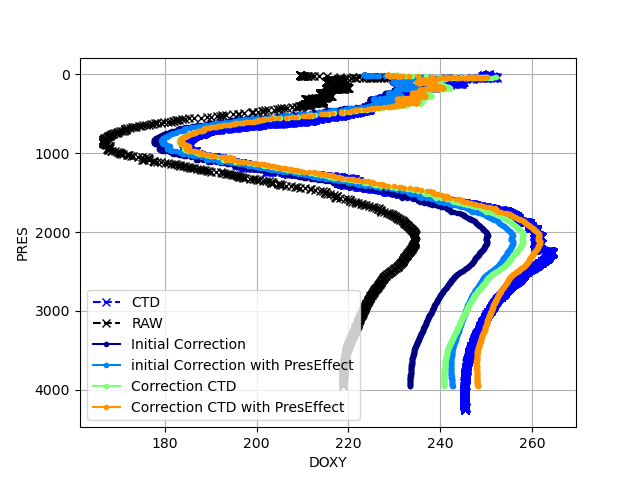

In [50]:
#corr_test_CK = np.array([params_to_keep[0]*params_Gain_CTD_CK[0],derive_final,params_no_corr_pressure[0]])
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        delta_T_Sprof_en_cours = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        if nb_segment>1:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof_en_cours)
            if index > 0:
                index = index -1
            dict_corr = {'Initial Correction' : corr_final_without_pressure_correction[index,:],'initial Correction with PresEffect' : corr_final_with_pressure_correction[index,:],'Correction CTD' : corr_final_CTD_without_pressure_correction[index,:],
                     'Correction CTD with PresEffect' : corr_final_CTD_with_pressure_correction[index,:]}
        else:
            dict_corr = {'Initial Correction' : corr_final_without_pressure_correction,'initial Correction with PresEffect' : corr_final_with_pressure_correction,'Correction CTD' : corr_final_CTD_without_pressure_correction,
                     'Correction CTD with PresEffect' : corr_final_CTD_with_pressure_correction}
            
        
        _=plot_cmp_ARGO_CTD(ds_cruise,ds_cycle,dict_corr,launch_date,pcoef2,pcoef3) 
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_differents_corr_with_CTD.png'))

        

# Choose between 4 corrections 
- Initial correction
- Intial correction with CTD gain
- Initial correction with pressure effect
- Initial correction with CTD gain and pressure effect

In [51]:
#
# Which correction to apply (without or with pressure correction).
#
corr_to_apply  = 4 #3
if corr_to_apply == 1:
    corr_final_to_use = corr_final_without_pressure_correction
    perr_to_use = perr_final
elif corr_to_apply == 2 :
    corr_final_to_use = corr_final_with_pressure_correction
    comment_corr = comment_corr + ' and a pressure effect'
    perr_to_use = perr_final_pressure
elif corr_to_apply == 3:
    corr_final_to_use = corr_final_CTD_without_pressure_correction
    comment_corr = comment_corr + ' and CTD Gain'
    perr_to_use = perr_final_CTD
else:
    corr_final_to_use = corr_final_CTD_with_pressure_correction
    comment_corr = comment_corr + ' and CTD Gain and pressure effect'
    perr_to_use = perr_final_CTD_with_pressure

comment_corr = 'Final correction : '+ comment_corr
print(comment_corr)
print(corr_final_to_use)
print(perr_to_use)

Final correction : Correction with a NCEP CarryOver Gain and CTD Gain and pressure effect
[1.09126702 0.         0.05351732]
[0.0037922496148080995, 0.0, 0.0007276860464291397]


In [52]:
dict_corr1 = {'Gain WOA' : np.stack((params_Gain_WOA,perr_Gain_WOA),axis=0),'Gain/Derive WOA':np.stack((params_Gain_Derive_WOA,perr_Gain_Derive_WOA),axis=0),
             'Gain NCEP' : np.stack((params_Gain_NCEP,perr_Gain_NCEP),axis=0),'Gain Ncep CarryOver' : np.stack((params_Gain_NCEP_CarryOver,perr_Gain_NCEP_CarryOver),axis=0),
             'Gain/Derive Ncep':np.stack((params_Gain_Derive_NCEP,perr_Gain_Derive_NCEP),axis=0),'Gain/Derive Ncep CarryOver':np.stack((params_Gain_Derive_NCEP_CarryOver,perr_Gain_Derive_NCEP_CarryOver),axis=0)}


dict_corr2 = {'Gain/Derive Piece WOA' : np.stack((params_morceaux_Gain_Derive_WOA, perr_morceaux_Gain_Derive_WOA), axis=0),
             'Gain/Derive Piece Ncep' : np.stack((params_morceaux_Gain_Derive_NCEP,perr_morceaux_Gain_Derive_NCEP),axis=0),'Gain/Derive Ncep Piece CarryOver' : np.stack((params_morceaux_Gain_Derive_CarryOver,perr_morceaux_Gain_Derive_CarryOver),axis=0),
            'Gain/Derive Ncep':np.stack((params_Gain_Derive_NCEP,perr_Gain_Derive_NCEP),axis=0),'Gain NCEP':np.stack((params_Gain_NCEP,perr_Gain_NCEP),axis=0)}

dict_corr3 = {'Initial' : np.stack((corr_final_without_pressure_correction, perr_final), axis=0),
             'Initial with pressure effect' : np.stack((corr_final_with_pressure_correction,perr_final_pressure),axis=0),'Initial with CTD Gain' : np.stack((corr_final_CTD_without_pressure_correction,perr_final_CTD),axis=0),
             'Initial with CTD Gain and pressure effect' : np.stack((corr_final_CTD_with_pressure_correction,perr_final_CTD_with_pressure),axis=0)}

dict_corr4 = {comment_corr : np.stack((corr_final_to_use,perr_to_use),axis=0)}

dict_corr = dict_corr1 | dict_corr2 | dict_corr3 | dict_corr4
write_param_results(dict_corr,num_float,fic_res_ASCII)

ecriture fichier


Final Correction
Number of pieces : 1
[1.09126702 0.         0.05351732]
[0.00379225 0.         0.00072769]
Final Correction
Number of pieces : 1
[1.09126702 0.         0.05351732] [0.00379225 0.         0.00072769]
[1.09126702 0.         0.05351732]


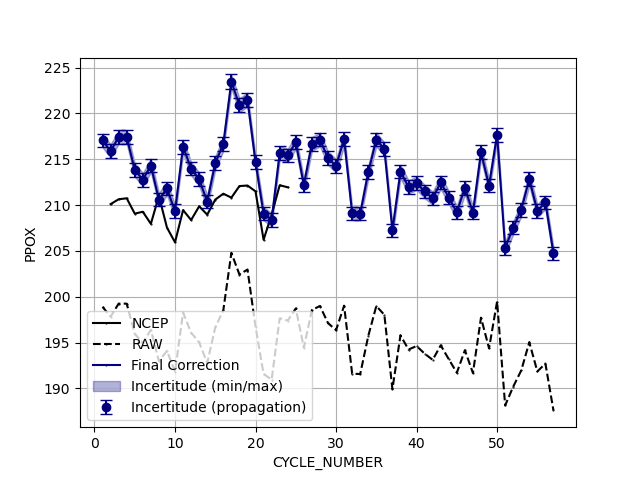

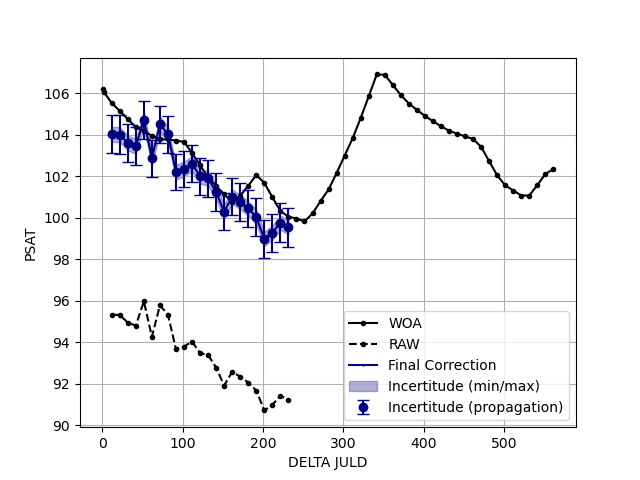

In [53]:
# Comparaison correction finale avec NCEP ET PSAT WOA
#dict_corr = {'Final Correction' : np.stack((corr_final_without_pressure_correction, perr_final_pressure), axis=0),'Final Correction2' : np.stack((corr_final_without_pressure_correction, perr_final_pressure), axis=0)}
dict_corr = {'Final Correction' : np.stack((corr_final_to_use, perr_to_use), axis=0)}
#if nb_segment==1:
#    breakpoint_list=[[]]*len(dict_corr)
#else:
#    breakpoint_list = [breaks_to_keep]*len(dict_corr)

breakpoint_list = [breaks_to_keep]*len(dict_corr)

_=plot_cmp_corr_NCEP_with_error(dict_corr,breakpoint_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_NCEP_final_corr.png'))
_=plot_cmp_corr_WOA_with_error(dict_corr,breakpoint_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_PSATWOA_final_corr.png'))

# Final plots

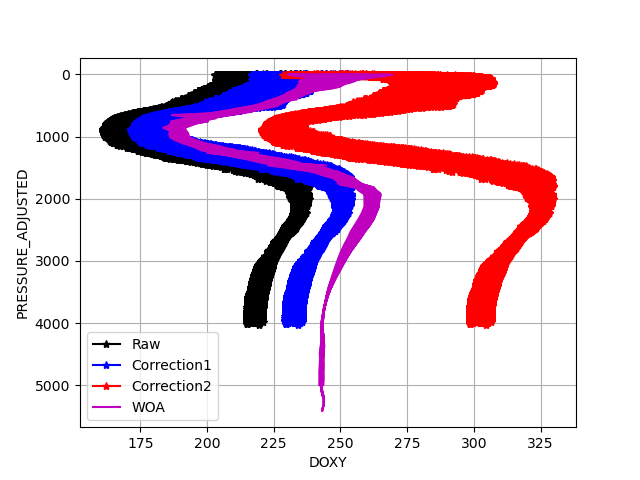

In [54]:
plot_cmp_correction_with_WOA(ds_argo_Sprof,delta_T_Sprof,breaks_to_keep,corr_final_without_pressure_correction,corr_final_to_use,ds_woa_interp_on_ARGO,str_chaine,
                            pcoef2,pcoef3)

# B File Correction

In [55]:
# BR/BD files correction
val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
fic_argo.sort()


print(breaks_to_keep)

for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_nc,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    #fic_res2 = os.path.join(rep_fic_nc,os.path.basename(fic_en_cours))
    #fic_res2 = fic_res.replace('BR','BK',1)
    #fic_res2 = fic_res.replace('BD','BK',1)
    ds = xr.open_dataset(fic_en_cours,engine='argo')
    cycle_en_cours = ds['CYCLE_NUMBER'].values[0]
    juld_en_cours = ds['JULD'].values[0]
    delta_T_en_cours = diff_time_in_days(juld_en_cours,launch_date)
    if (cycle_en_cours >= first_cycle_to_use) & (cycle_en_cours<=last_cycle_to_use):
        if nb_segment>1:
            index = next((x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_en_cours),None)
            if index is None :
                if delta_T_en_cours < breaks_to_keep[0] :
                    index = 0
                elif delta_T_en_cours > breaks_to_keep[-1] :
                    index = len(breaks_to_keep) - 1
            if index > 0:
                index = index -1
            corr_final = corr_final_to_use[index,:]
        else :
            corr_final = corr_final_to_use
        
        coef_pres = corr_final[2]
        gain_final = corr_final[0]
        derive_final = corr_final[1]  
        coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, COEF_PRES ={coef_pres},OFFSET=0.000000'
        eq_corr = 'DOXY2 = DOXY / (1 + (Pcoef2*TEMP + coef3)*PRES/1000) * (1 + (Pcoef2*TEMP + coef_pres)*PRES/1000),DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365)+INCLINE_T*TEMP)*DOXY2'
        print(f'Correction de {fic_en_cours} avec {corr_final}')
        if os.path.exists(fic_res):
            os.remove(fic_res)
        corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,pcoef2,pcoef3,gain_final,derive_final,coef_pres,percent_relative_error)
        #corr_file_with_ppox(fic_en_cours,fic_res2,launch_date,comment_corr,coef_corr,eq_corr,pcoef2,pcoef3,gain_final,derive_final,coef_pres,percent_relative_error)

[9.51388889e-02 5.61531250e+02]
Correction de /Volumes/argo/gdac/dac/coriolis/6902982/profiles/BD6902982_001.nc avec [1.09126702 0.         0.05351732]
Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902982/profiles/D6902982_001.nc pour correction de l'effet de pression

Correction de /Volumes/argo/gdac/dac/coriolis/6902982/profiles/BD6902982_002.nc avec [1.09126702 0.         0.05351732]
Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902982/profiles/D6902982_002.nc pour correction de l'effet de pression

Correction de /Volumes/argo/gdac/dac/coriolis/6902982/profiles/BD6902982_003.nc avec [1.09126702 0.         0.05351732]
Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902982/profiles/D6902982_003.nc pour correction de l'effet de pression

Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902982/profiles/D6902982_003.nc pour correction de l'effet de pression

Correction de /Volumes/argo/gdac/dac/cor